# Análisis y Predicción de Customer Churn en Telco

## Descripción del Proyecto

Este notebook presenta un análisis completo de predicción de abandono de clientes (Customer Churn) en una empresa de telecomunicaciones. El objetivo es desarrollar modelos de Machine Learning que permitan identificar clientes con alta probabilidad de abandonar el servicio, facilitando estrategias de retención proactivas.

## Metodología

1. **Análisis Exploratorio de Datos (EDA)**: Comprensión profunda del dataset y sus características
2. **Preprocesamiento**: Limpieza, transformación y preparación de datos
3. **Feature Engineering**: Creación de características derivadas relevantes
4. **Modelado**: Entrenamiento y comparación de múltiples algoritmos
5. **Optimización**: Ajuste de hiperparámetros y manejo de desbalanceo
6. **Evaluación**: Análisis de rendimiento con métricas apropiadas
7. **Interpretabilidad**: Análisis de importancia de características

## Dataset

El dataset contiene información de 7,043 clientes con 21 variables que incluyen:
- Información demográfica (género, edad, dependientes)
- Servicios contratados (teléfono, internet, streaming)
- Información de cuenta (tipo de contrato, método de pago, cargos)
- Variable objetivo: Churn (Yes/No)


## 0. Importación de librerías

Importamos todas las librerías necesarias para manejo de archivos, manipulación de datos, visualización, pruebas estadísticas, preprocesamiento, modelos, métricas, desbalanceo y optimización



In [56]:
# Importación de librerías necesarias
import os
import warnings
warnings.filterwarnings('ignore')

# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Manejo de desbalanceo
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Optimización
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")


✓ Librerías importadas correctamente


## 0.1 Configuración de Reproducibilidad

Esta celda configura el comportamiento de las semillas aleatorias para el notebook:

**🔒 MODO REPRODUCIBLE (`REPRODUCIBLE_MODE = True`):**
- Usa semilla fija (42) para garantizar resultados idénticos en cada ejecución
- Ideal para: documentación, presentaciones, validación de resultados

**🔬 MODO EXPERIMENTAL (`REPRODUCIBLE_MODE = False`):**
- Usa semillas aleatorias diferentes en cada ejecución
- Ideal para: experimentación, prueba de robustez, exploración de algoritmos


In [57]:
# ============================================================================
# CONFIGURACIÓN GLOBAL DE REPRODUCIBILIDAD
# ============================================================================


# Configuración de reproducibilidad
REPRODUCIBLE_MODE = False  # True = resultados fijos, False = resultados variables

if REPRODUCIBLE_MODE:
    RANDOM_STATE = 42
    print("🔒 MODO REPRODUCIBLE ACTIVADO")
    print("   → Semilla fija: 42")
    print("   → Los resultados serán idénticos en cada ejecución")
else:
    RANDOM_STATE = np.random.randint(0, 10000)
    print("🔬 MODO EXPERIMENTAL ACTIVADO")
    print(f"   → Semilla aleatoria: {RANDOM_STATE}")
    print("   → Los resultados variarán en cada ejecución")


🔬 MODO EXPERIMENTAL ACTIVADO
   → Semilla aleatoria: 7109
   → Los resultados variarán en cada ejecución


## 1. Carga y Exploración Inicial de Datos

Cargamos el dataset y realizamos una primera inspección para entender su estructura.


In [58]:
# Carga del dataset con manejo robusto de rutas

def cargar_datos():
    """Carga el dataset desde diferentes ubicaciones posibles"""
    drive_mounted = False
    # Intentar montar Google Drive
    try:
        print("Montando Google Drive...")
        drive.mount('/content/drive', force_remount=True)
        print("Google Drive montado exitosamente.")
        drive_mounted = True
    except Exception as e:
        print(f"No se pudo montar Google Drive: {e}")

    rutas_posibles = [
        'WA_Fn-UseC_-Telco-Customer-Churn.csv',
        './WA_Fn-UseC_-Telco-Customer-Churn.csv',
        '../WA_Fn-UseC_-Telco-Customer-Churn.csv',
    ]
    if drive_mounted:
        # Añadir ruta de Google Drive común
        rutas_posibles.append('/content/drive/MyDrive/WA_Fn-UseC_-Telco-Customer-Churn.csv')
        # Añadir la ruta especificada por el usuario (directorio del notebook)
        notebook_dir_in_drive = '/content/drive/MyDrive/Colab Notebooks/Defensa-Proyecto'
        rutas_posibles.append(os.path.join(notebook_dir_in_drive, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
        # Añadir la ruta en el directorio actual de Colab si está dentro de Drive
        current_colab_dir = os.getcwd()
        if '/content/drive/MyDrive' in current_colab_dir:
            rutas_posibles.append(os.path.join(current_colab_dir, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))


    for ruta in rutas_posibles:
        if os.path.exists(ruta):
            print(f"✓ Dataset encontrado en: {ruta}")
            return pd.read_csv(ruta)

    raise FileNotFoundError("No se encontró el archivo CSV. Verifica la ruta.")

# Cargar datos
df = cargar_datos()

# Información básica
print(f"\nDimensiones del dataset: {df.shape[0]} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas del dataset:")
df.head()


Montando Google Drive...
Mounted at /content/drive
Google Drive montado exitosamente.
✓ Dataset encontrado en: WA_Fn-UseC_-Telco-Customer-Churn.csv

Dimensiones del dataset: 7043 filas × 21 columnas

Primeras filas del dataset:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [59]:
# Información detallada del dataset
print("="*80)
print("INFORMACIÓN DEL DATASET")
print("="*80)

print("\n1. Tipos de datos:")
print(df.dtypes)

print("\n2. Información general:")
df.info()

print("\n3. Estadísticas descriptivas (variables numéricas):")
df.describe()


INFORMACIÓN DEL DATASET

1. Tipos de datos:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

2. Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-nu

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## 2. Análisis de Calidad de Datos

### 2.1 Detección de Valores Faltantes y Anomalías


In [60]:
# Análisis de valores faltantes
print("Valores faltantes por columna:")
missing = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Valores Faltantes': missing,
    'Porcentaje': missing_pct
})
print(missing_table[missing_table['Valores Faltantes'] > 0])

# Verificar tipo de dato de TotalCharges
print(f"\nTipo de dato de TotalCharges: {df['TotalCharges'].dtype}")
print(f"\nValores únicos en TotalCharges (primeros 10):")
print(df['TotalCharges'].unique()[:10])

# Identificar espacios en blanco en TotalCharges
espacios_blancos = df[df['TotalCharges'] == ' ']
print(f"\nRegistros con TotalCharges vacío: {len(espacios_blancos)}")
if len(espacios_blancos) > 0:
    print("\nCaracterísticas de registros con TotalCharges vacío:")
    print(espacios_blancos[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']].head())


Valores faltantes por columna:
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje]
Index: []

Tipo de dato de TotalCharges: object

Valores únicos en TotalCharges (primeros 10):
['29.85' '1889.5' '108.15' '1840.75' '151.65' '820.5' '1949.4' '301.9'
 '3046.05' '3487.95']

Registros con TotalCharges vacío: 11

Características de registros con TotalCharges vacío:
      customerID  tenure  MonthlyCharges TotalCharges
488   4472-LVYGI       0           52.55             
753   3115-CZMZD       0           20.25             
936   5709-LVOEQ       0           80.85             
1082  4367-NUYAO       0           25.75             
1340  1371-DWPAZ       0           56.05             


### 2.2 Limpieza de Datos

Identificamos que `TotalCharges` contiene espacios en blanco y está almacenado como texto. Procedemos a limpiar estos datos.


In [61]:
# Limpieza de TotalCharges
# Convertir espacios en blanco a NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# Convertir a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Análisis de registros con TotalCharges faltante
print(f"Registros con TotalCharges NaN: {df['TotalCharges'].isna().sum()}")

# Estrategia: Para clientes nuevos (tenure=0), TotalCharges debería ser igual a MonthlyCharges
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = df.loc[df['TotalCharges'].isna(), 'MonthlyCharges']

print(f"\nDespués de la imputación:")
print(f"Registros con TotalCharges NaN: {df['TotalCharges'].isna().sum()}")

# Verificar que no hay valores faltantes
print(f"\nTotal de valores faltantes en el dataset: {df.isnull().sum().sum()}")


Registros con TotalCharges NaN: 11

Después de la imputación:
Registros con TotalCharges NaN: 0

Total de valores faltantes en el dataset: 0


## 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Análisis de la Variable Objetivo (Churn)


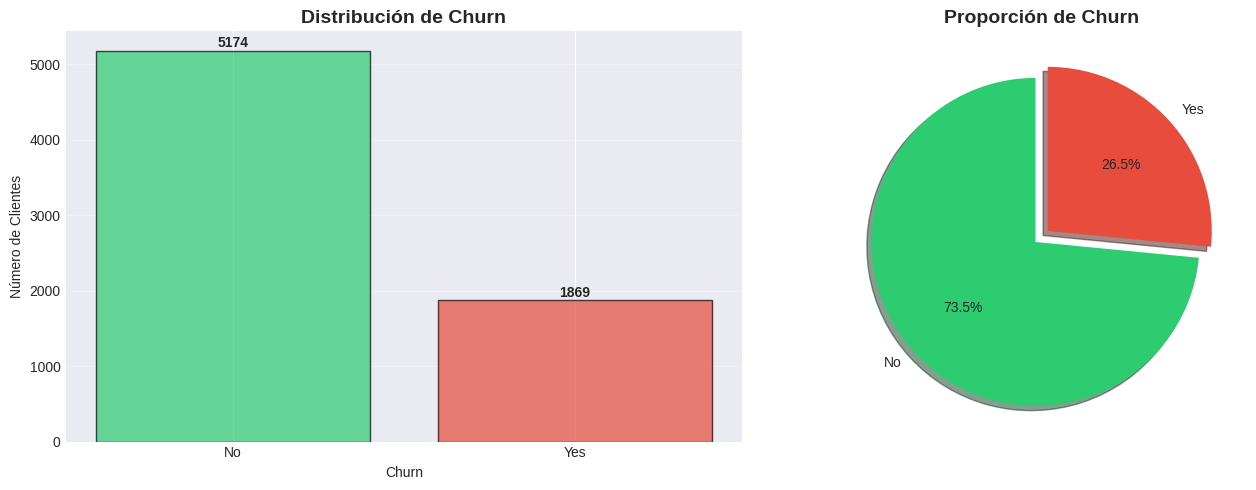


Estadísticas de Churn:
Total de clientes: 7043
Clientes que NO abandonaron: 5174 (73.46%)
Clientes que SÍ abandonaron: 1869 (26.54%)

Ratio de desbalanceo: 2.77:1


In [62]:
# Análisis de la distribución de Churn

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
churn_counts = df['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values, color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0].set_title('Distribución de Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Número de Clientes')
axes[0].grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(churn_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Proporción de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas
print("\nEstadísticas de Churn:")
print(f"Total de clientes: {len(df)}")
print(f"Clientes que NO abandonaron: {churn_counts['No']} ({100*churn_counts['No']/len(df):.2f}%)")
print(f"Clientes que SÍ abandonaron: {churn_counts['Yes']} ({100*churn_counts['Yes']/len(df):.2f}%)")
print(f"\nRatio de desbalanceo: {churn_counts['No']/churn_counts['Yes']:.2f}:1")

### 3.2 Análisis de Variables Categóricas

Analizamos la relación entre las variables categóricas y el churn.


Variables categóricas a analizar: 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


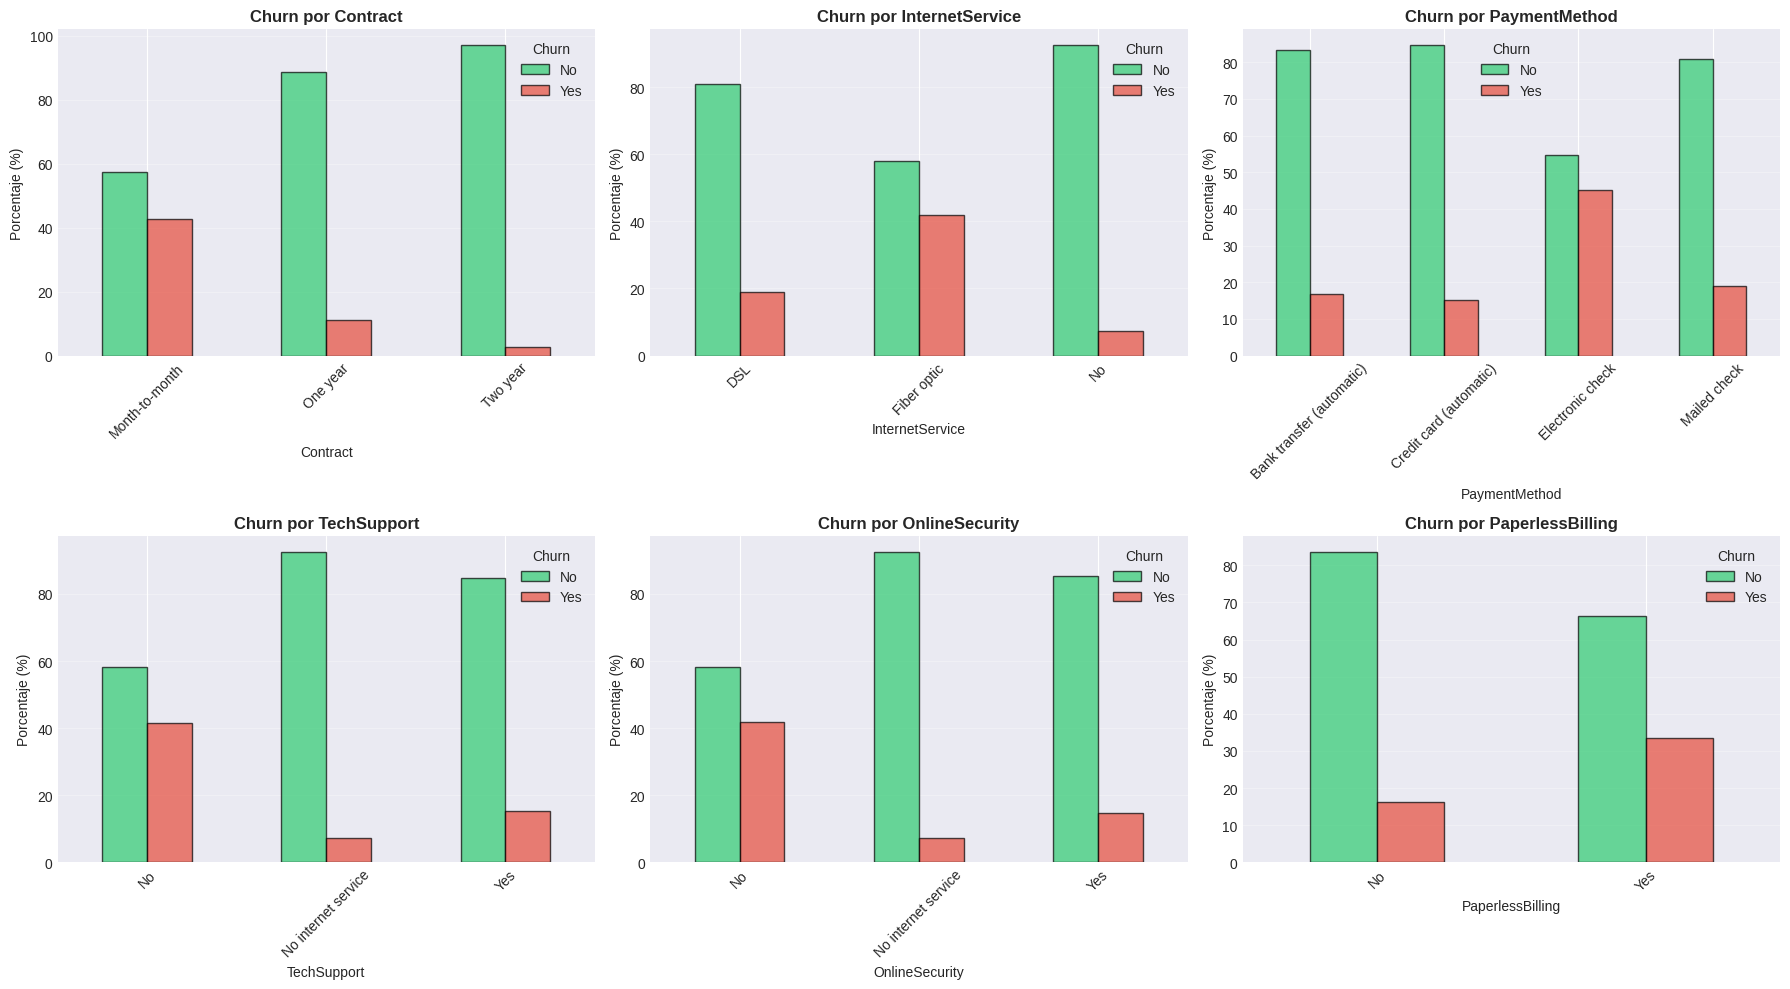


Tasa de Churn por categoría:


Contract:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64

InternetService:
InternetService
Fiber optic    41.892765
DSL            18.959108
No              7.404980
Name: Churn, dtype: float64

PaymentMethod:
PaymentMethod
Electronic check             45.285412
Mailed check                 19.106700
Bank transfer (automatic)    16.709845
Credit card (automatic)      15.243101
Name: Churn, dtype: float64

TechSupport:
TechSupport
No                     41.635474
Yes                    15.166341
No internet service     7.404980
Name: Churn, dtype: float64

OnlineSecurity:
OnlineSecurity
No                     41.766724
Yes                    14.611194
No internet service     7.404980
Name: Churn, dtype: float64

PaperlessBilling:
PaperlessBilling
Yes    33.565092
No     16.330084
Name: Churn, dtype: float64


In [63]:
# Identificar variables categóricas (excluyendo customerID y Churn)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')
categorical_cols.remove('Churn')

print(f"Variables categóricas a analizar: {len(categorical_cols)}")
print(categorical_cols)

# Visualizar las variables categóricas más importantes
important_cats = ['Contract', 'InternetService', 'PaymentMethod', 'TechSupport',
                  'OnlineSecurity', 'PaperlessBilling']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, col in enumerate(important_cats):
    # Crear tabla de contingencia
    ct = pd.crosstab(df[col], df['Churn'], normalize='index') * 100

    # Graficar
    ct.plot(kind='bar', ax=axes[idx], color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Churn por {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Porcentaje (%)')
    axes[idx].legend(title='Churn', labels=['No', 'Yes'])
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análisis estadístico
print("\nTasa de Churn por categoría:\n")
for col in important_cats:
    print(f"\n{col}:")
    churn_rate = df.groupby(col)['Churn'].apply(lambda x: (x=='Yes').sum()/len(x)*100)
    print(churn_rate.sort_values(ascending=False))


### 3.3 Análisis de Variables Numéricas


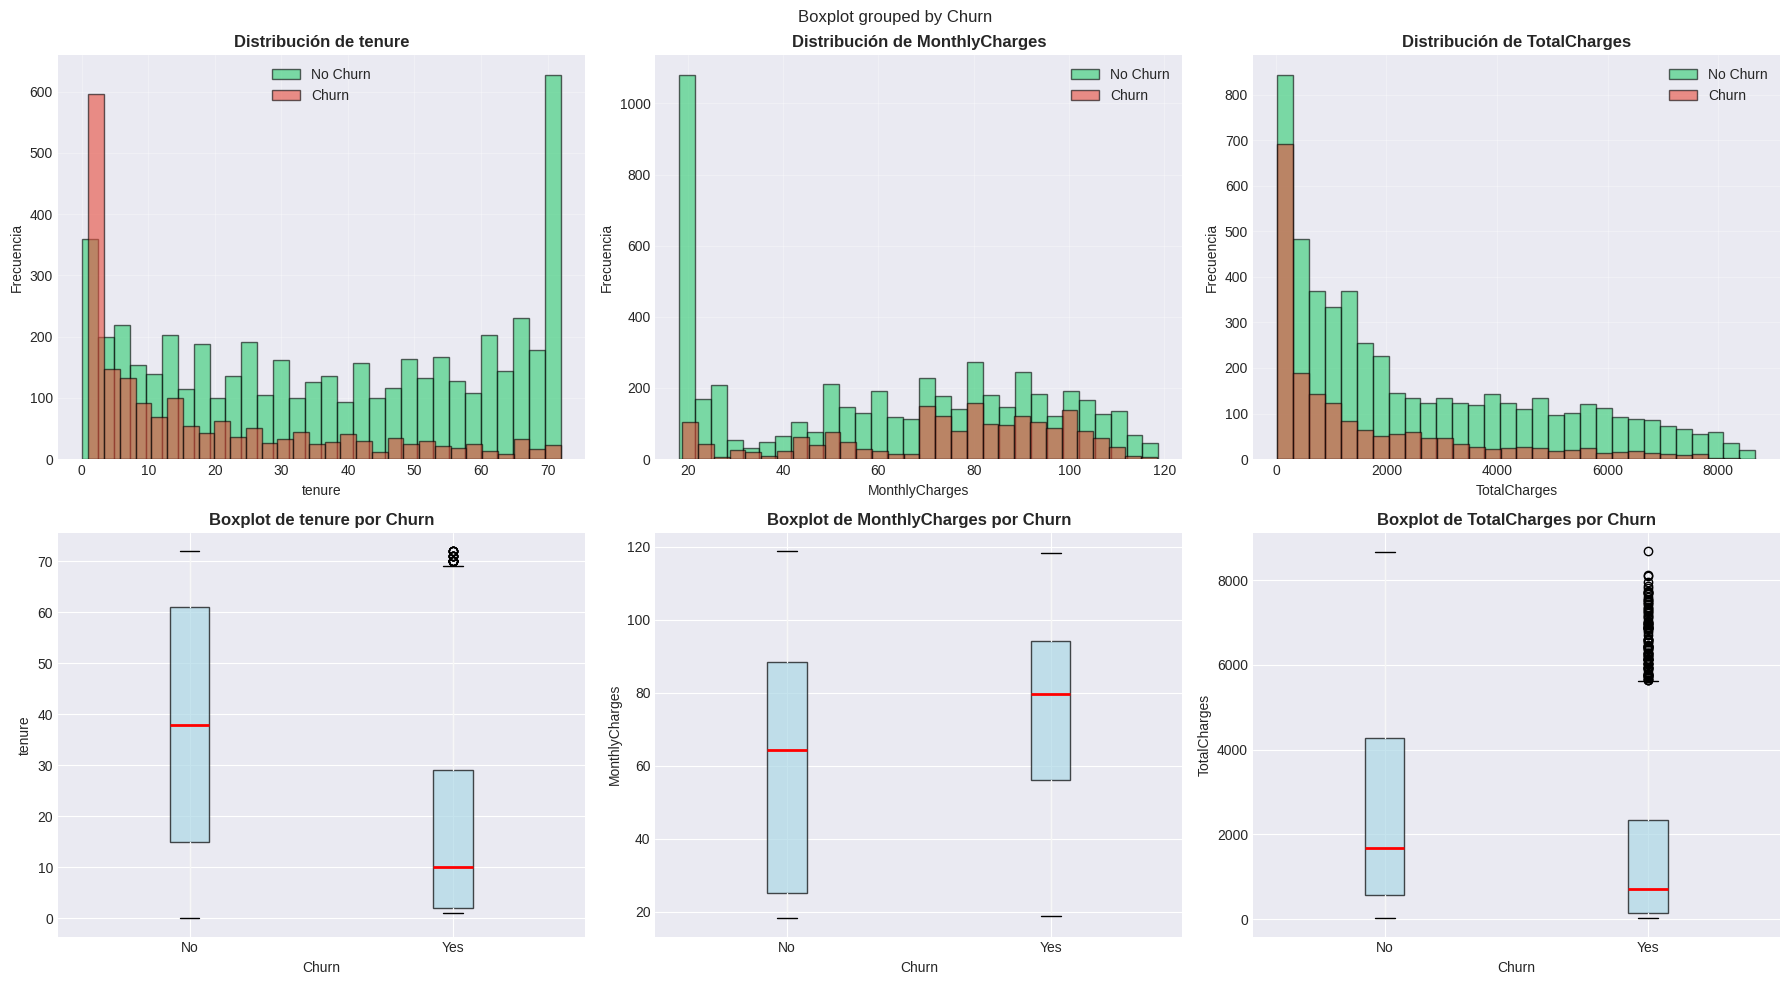


Estadísticas de variables numéricas por Churn:

Churn                          No          Yes
tenure         count  5174.000000  1869.000000
               mean     37.569965    17.979133
               std      24.113777    19.531123
               min       0.000000     1.000000
               25%      15.000000     2.000000
               50%      38.000000    10.000000
               75%      61.000000    29.000000
               max      72.000000    72.000000
MonthlyCharges count  5174.000000  1869.000000
               mean     61.265124    74.441332
               std      31.092648    24.666053
               min      18.250000    18.850000
               25%      25.100000    56.150000
               50%      64.425000    79.650000
               75%      88.400000    94.200000
               max     118.750000   118.350000
TotalCharges   count  5174.000000  1869.000000
               mean   2549.999497  1531.796094
               std    2329.858843  1890.822994
           

In [64]:
# Variables numéricas
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Visualización de distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, col in enumerate(numerical_cols):
    # Histograma
    axes[0, idx].hist(df[df['Churn']=='No'][col], bins=30, alpha=0.6, label='No Churn', color='#2ecc71', edgecolor='black')
    axes[0, idx].hist(df[df['Churn']=='Yes'][col], bins=30, alpha=0.6, label='Churn', color='#e74c3c', edgecolor='black')
    axes[0, idx].set_title(f'Distribución de {col}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel('Frecuencia')
    axes[0, idx].legend()
    axes[0, idx].grid(alpha=0.3)

    # Boxplot
    df.boxplot(column=col, by='Churn', ax=axes[1, idx], patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7),
               medianprops=dict(color='red', linewidth=2))
    axes[1, idx].set_title(f'Boxplot de {col} por Churn', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('Churn')
    axes[1, idx].set_ylabel(col)
    plt.sca(axes[1, idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.tight_layout()
plt.show()

# Estadísticas por grupo
print("\nEstadísticas de variables numéricas por Churn:\n")
print(df.groupby('Churn')[numerical_cols].describe().T)


### 3.4 Análisis de Correlaciones


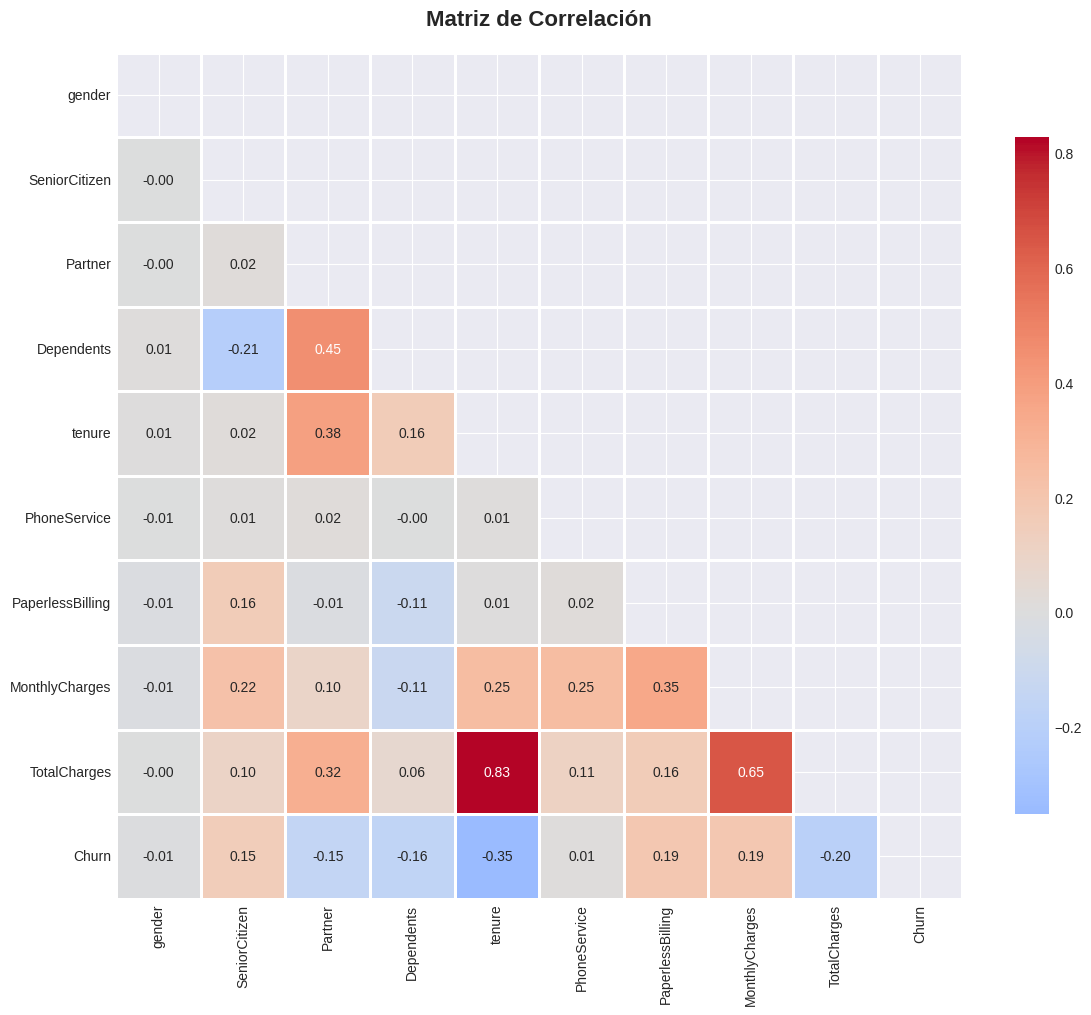


Correlaciones con Churn (ordenadas por valor absoluto):

tenure             -0.352229
TotalCharges       -0.198347
MonthlyCharges      0.193356
PaperlessBilling    0.191825
Dependents         -0.164221
SeniorCitizen       0.150889
Partner            -0.150448
PhoneService        0.011942
gender             -0.008612
Name: Churn, dtype: float64


In [65]:
# Preparar datos para correlación

df_corr = df.copy()

# Convertir variables categóricas binarias a numéricas
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if col in df_corr.columns:
        df_corr[col] = df_corr[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# Seleccionar solo columnas numéricas
numeric_df = df_corr.select_dtypes(include=[np.number])

# Calcular matriz de correlación
correlation_matrix = numeric_df.corr()

# Visualizar
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlaciones más fuertes con Churn
print("\nCorrelaciones con Churn (ordenadas por valor absoluto):\n")
churn_corr = correlation_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)
print(churn_corr)


## 4. Feature Engineering

Creamos nuevas características que pueden mejorar el rendimiento de los modelos.


In [66]:
# Crear copia para feature engineering
df_fe = df.copy()

# 1. Ratio de cargos (cuánto paga mensualmente vs total)
df_fe['ChargeRatio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)  # +1 para evitar división por cero

# 2. Promedio de cargos mensuales basado en tenure
df_fe['AvgMonthlyCharges'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)

# 3. Categorizar tenure en grupos
df_fe['TenureGroup'] = pd.cut(df_fe['tenure'], bins=[0, 12, 24, 48, 72],
                               labels=['0-1 año', '1-2 años', '2-4 años', '4+ años'])

# 4. Total de servicios contratados
service_cols = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

df_fe['TotalServices'] = 0
for col in service_cols:
    df_fe['TotalServices'] += (df_fe[col] != 'No').astype(int)

# 5. Cliente senior con dependientes
df_fe['SeniorWithDependents'] = ((df_fe['SeniorCitizen'] == 1) & (df_fe['Dependents'] == 'Yes')).astype(int)

# 6. Contrato de alto valor (contrato largo + cargos altos)
df_fe['HighValueContract'] = ((df_fe['Contract'].isin(['One year', 'Two year'])) &
                               (df_fe['MonthlyCharges'] > df_fe['MonthlyCharges'].median())).astype(int)

print("Nuevas características creadas:")
new_features = ['ChargeRatio', 'AvgMonthlyCharges', 'TenureGroup', 'TotalServices',
                'SeniorWithDependents', 'HighValueContract']
print(df_fe[new_features].head(10))

print(f"\nDimensiones del dataset con nuevas características: {df_fe.shape}")


Nuevas características creadas:
   ChargeRatio  AvgMonthlyCharges TenureGroup  TotalServices  \
0     0.967585          14.925000     0-1 año              2   
1     0.030124          53.985714    2-4 años              4   
2     0.493358          36.050000     0-1 año              4   
3     0.022967          40.016304    2-4 años              4   
4     0.463151          50.550000     0-1 año              2   
5     0.121302          91.166667     0-1 año              5   
6     0.045683          84.756522    1-2 años              4   
7     0.098217          27.445455     0-1 año              2   
8     0.034394         105.036207    2-4 años              6   
9     0.016094          55.364286     4+ años              4   

   SeniorWithDependents  HighValueContract  
0                     0                  0  
1                     0                  0  
2                     0                  0  
3                     0                  0  
4                     0               

## 5. Preparación de Datos para Modelado

### 5.1 Codificación de Variables y División de Datos


In [67]:
# Preparar datos para modelado
df_model = df_fe.copy()

# Eliminar customerID (no es útil para predicción)
df_model = df_model.drop('customerID', axis=1)

# Convertir TenureGroup a string para encoding
df_model['TenureGroup'] = df_model['TenureGroup'].astype(str)

# Separar características y variable objetivo
X = df_model.drop('Churn', axis=1)
y = df_model['Churn'].map({'Yes': 1, 'No': 0})

print(f"Dimensiones de X: {X.shape}")
print(f"Dimensiones de y: {y.shape}")
print(f"\nDistribución de la variable objetivo:")
print(y.value_counts())

# Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nCaracterísticas numéricas ({len(numeric_features)}): {numeric_features}")
print(f"\nCaracterísticas categóricas ({len(categorical_features)}): {categorical_features}")


Dimensiones de X: (7043, 25)
Dimensiones de y: (7043,)

Distribución de la variable objetivo:
Churn
0    5174
1    1869
Name: count, dtype: int64

Características numéricas (9): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'ChargeRatio', 'AvgMonthlyCharges', 'TotalServices', 'SeniorWithDependents', 'HighValueContract']

Características categóricas (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TenureGroup']


In [68]:
from sklearn.model_selection import train_test_split

# División estratificada de datos (80% train, 20% test)
# Usa la semilla configurada en la celda de configuración
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"🎲 Usando semilla aleatoria: {RANDOM_STATE}")

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nDistribución de Churn en entrenamiento:")
print(y_train.value_counts(normalize=True))

print(f"\nDistribución de Churn en prueba:")
print(y_test.value_counts(normalize=True))

🎲 Usando semilla aleatoria: 7109
Tamaño del conjunto de entrenamiento: 5634 (80.0%)
Tamaño del conjunto de prueba: 1409 (20.0%)

Distribución de Churn en entrenamiento:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Distribución de Churn en prueba:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


### 5.2 Pipeline de Preprocesamiento

Creamos un pipeline que:
1. Codifica variables categóricas (One-Hot Encoding)
2. Escala variables numéricas (StandardScaler)


In [69]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Crear transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Crear preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Ajustar y transformar datos de entrenamiento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Obtener nombres de características después del encoding
feature_names = (
    numeric_features +
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(categorical_features).tolist()
)

print(f"Dimensiones después del preprocesamiento:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")
print(f"\nTotal de características: {len(feature_names)}")


Dimensiones después del preprocesamiento:
X_train: (5634, 39)
X_test: (1409, 39)

Total de características: 39


## 6. Entrenamiento de Modelos Baseline

Entrenamos múltiples modelos para establecer una línea base de rendimiento.


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definir modelos baseline
# Todos los modelos usan la semilla configurada (RANDOM_STATE)
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True),
    'KNN': KNeighborsClassifier()
}

# Entrenar y evaluar cada modelo
results = []

print("Entrenando modelos baseline...\n")
print("="*80)

for name, model in models.items():
    print(f"\nEntrenando {name}...")

    # Entrenar
    model.fit(X_train_processed, y_train)

    # Predicciones
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1] if hasattr(model, 'predict_proba') else None

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    if roc_auc:
        print(f"  ROC-AUC: {roc_auc:.4f}")

# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("\nRESUMEN DE RESULTADOS BASELINE:\n")
print(results_df.to_string(index=False))


Entrenando modelos baseline...


Entrenando Logistic Regression...
  Accuracy: 0.7963
  Precision: 0.6399
  Recall: 0.5321
  F1-Score: 0.5810
  ROC-AUC: 0.8458

Entrenando Decision Tree...
  Accuracy: 0.7275
  Precision: 0.4865
  Recall: 0.4813
  F1-Score: 0.4839
  ROC-AUC: 0.6510

Entrenando Random Forest...
  Accuracy: 0.7885
  Precision: 0.6310
  Recall: 0.4893
  F1-Score: 0.5512
  ROC-AUC: 0.8262

Entrenando Gradient Boosting...
  Accuracy: 0.7977
  Precision: 0.6459
  Recall: 0.5267
  F1-Score: 0.5803
  ROC-AUC: 0.8437

Entrenando XGBoost...
  Accuracy: 0.7857
  Precision: 0.6104
  Recall: 0.5321
  F1-Score: 0.5686
  ROC-AUC: 0.8298

Entrenando SVM...
  Accuracy: 0.7970
  Precision: 0.6528
  Recall: 0.5027
  F1-Score: 0.5680
  ROC-AUC: 0.7991

Entrenando KNN...
  Accuracy: 0.7771
  Precision: 0.5926
  Recall: 0.5134
  F1-Score: 0.5501
  ROC-AUC: 0.7809


RESUMEN DE RESULTADOS BASELINE:

             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.796

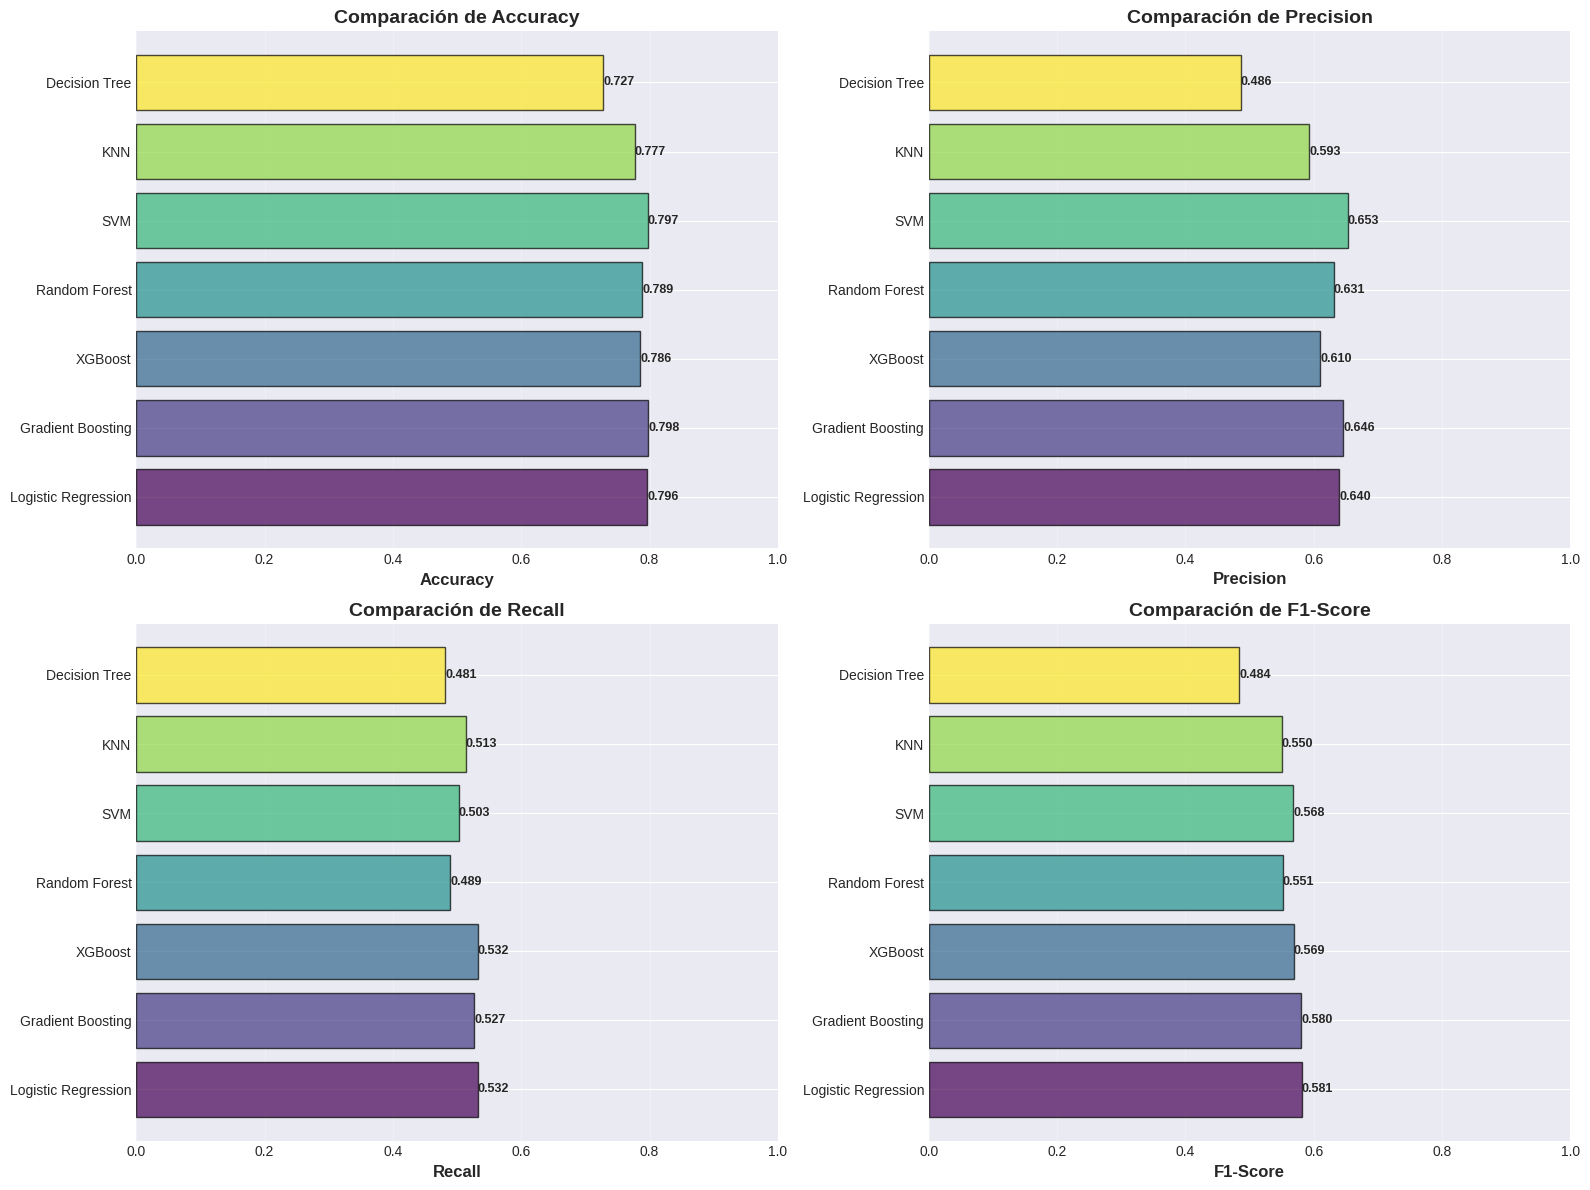

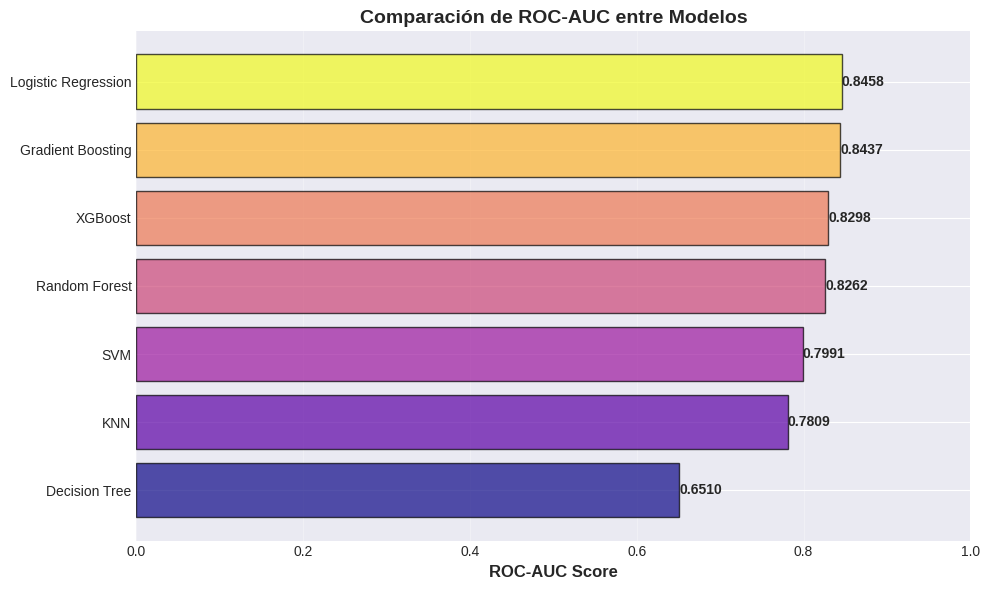

In [71]:
# Visualizar comparación de modelos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]
    bars = ax.barh(results_df['Modelo'], results_df[metric], color=colors, edgecolor='black', alpha=0.7)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Comparación de {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.grid(axis='x', alpha=0.3)

    # Añadir valores en las barras
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.3f}',
                ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# ROC-AUC separado
plt.figure(figsize=(10, 6))
results_roc = results_df.dropna(subset=['ROC-AUC']).sort_values('ROC-AUC')
bars = plt.barh(results_roc['Modelo'], results_roc['ROC-AUC'],
                color=plt.cm.plasma(np.linspace(0, 1, len(results_roc))),
                edgecolor='black', alpha=0.7)
plt.xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('Comparación de ROC-AUC entre Modelos', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 7. Manejo del Desbalanceo de Clases

El dataset presenta un desbalanceo significativo (73% No Churn vs 27% Churn). Aplicamos SMOTE (Synthetic Minority Over-sampling Technique) para balancear las clases.


In [72]:
from imblearn.over_sampling import SMOTE
# Aplicar SMOTE con la semilla configurada
smote = SMOTE(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print(f"🎲 SMOTE usando semilla: {RANDOM_STATE}\n")

print("Distribución ANTES de SMOTE:")
print(y_train.value_counts())
print(f"\nRatio: {y_train.value_counts()[0]/y_train.value_counts()[1]:.2f}:1")

print("\n" + "="*60)

print("\nDistribución DESPUÉS de SMOTE:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\nRatio: {pd.Series(y_train_balanced).value_counts()[0]/pd.Series(y_train_balanced).value_counts()[1]:.2f}:1")

print(f"\nNuevas dimensiones del conjunto de entrenamiento: {X_train_balanced.shape}")

🎲 SMOTE usando semilla: 7109

Distribución ANTES de SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

Ratio: 2.77:1


Distribución DESPUÉS de SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64

Ratio: 1.00:1

Nuevas dimensiones del conjunto de entrenamiento: (8278, 39)


### 7.1 Reentrenamiento con Datos Balanceados


In [73]:
# Seleccionar los mejores modelos para reentrenar con SMOTE
# Todos usan la semilla configurada (RANDOM_STATE)
best_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': xgb.XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, eval_metric='logloss')
}

# Entrenar con datos balanceados
results_balanced = []

print("Entrenando modelos con datos balanceados...\n")
print("="*80)

for name, model in best_models.items():
    print(f"\nEntrenando {name} con SMOTE...")

    # Entrenar
    model.fit(X_train_balanced, y_train_balanced)

    # Predicciones
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results_balanced.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

# Crear DataFrame con resultados
results_balanced_df = pd.DataFrame(results_balanced)
results_balanced_df = results_balanced_df.sort_values('ROC-AUC', ascending=False)

print("\n" + "="*80)
print("\nRESUMEN DE RESULTADOS CON SMOTE:\n")
print(results_balanced_df.to_string(index=False))


Entrenando modelos con datos balanceados...


Entrenando Logistic Regression con SMOTE...
  Accuracy: 0.7551
  Precision: 0.5258
  Recall: 0.7888
  F1-Score: 0.6310
  ROC-AUC: 0.8440

Entrenando Random Forest con SMOTE...
  Accuracy: 0.7999
  Precision: 0.6307
  Recall: 0.5936
  F1-Score: 0.6116
  ROC-AUC: 0.8287

Entrenando Gradient Boosting con SMOTE...
  Accuracy: 0.7885
  Precision: 0.5936
  Recall: 0.6444
  F1-Score: 0.6179
  ROC-AUC: 0.8391

Entrenando XGBoost con SMOTE...
  Accuracy: 0.7871
  Precision: 0.6076
  Recall: 0.5588
  F1-Score: 0.5822
  ROC-AUC: 0.8263


RESUMEN DE RESULTADOS CON SMOTE:

             Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.755145   0.525847 0.788770  0.631016 0.844005
  Gradient Boosting  0.788502   0.593596 0.644385  0.617949 0.839137
      Random Forest  0.799858   0.630682 0.593583  0.611570 0.828670
            XGBoost  0.787083   0.607558 0.558824  0.582173 0.826268


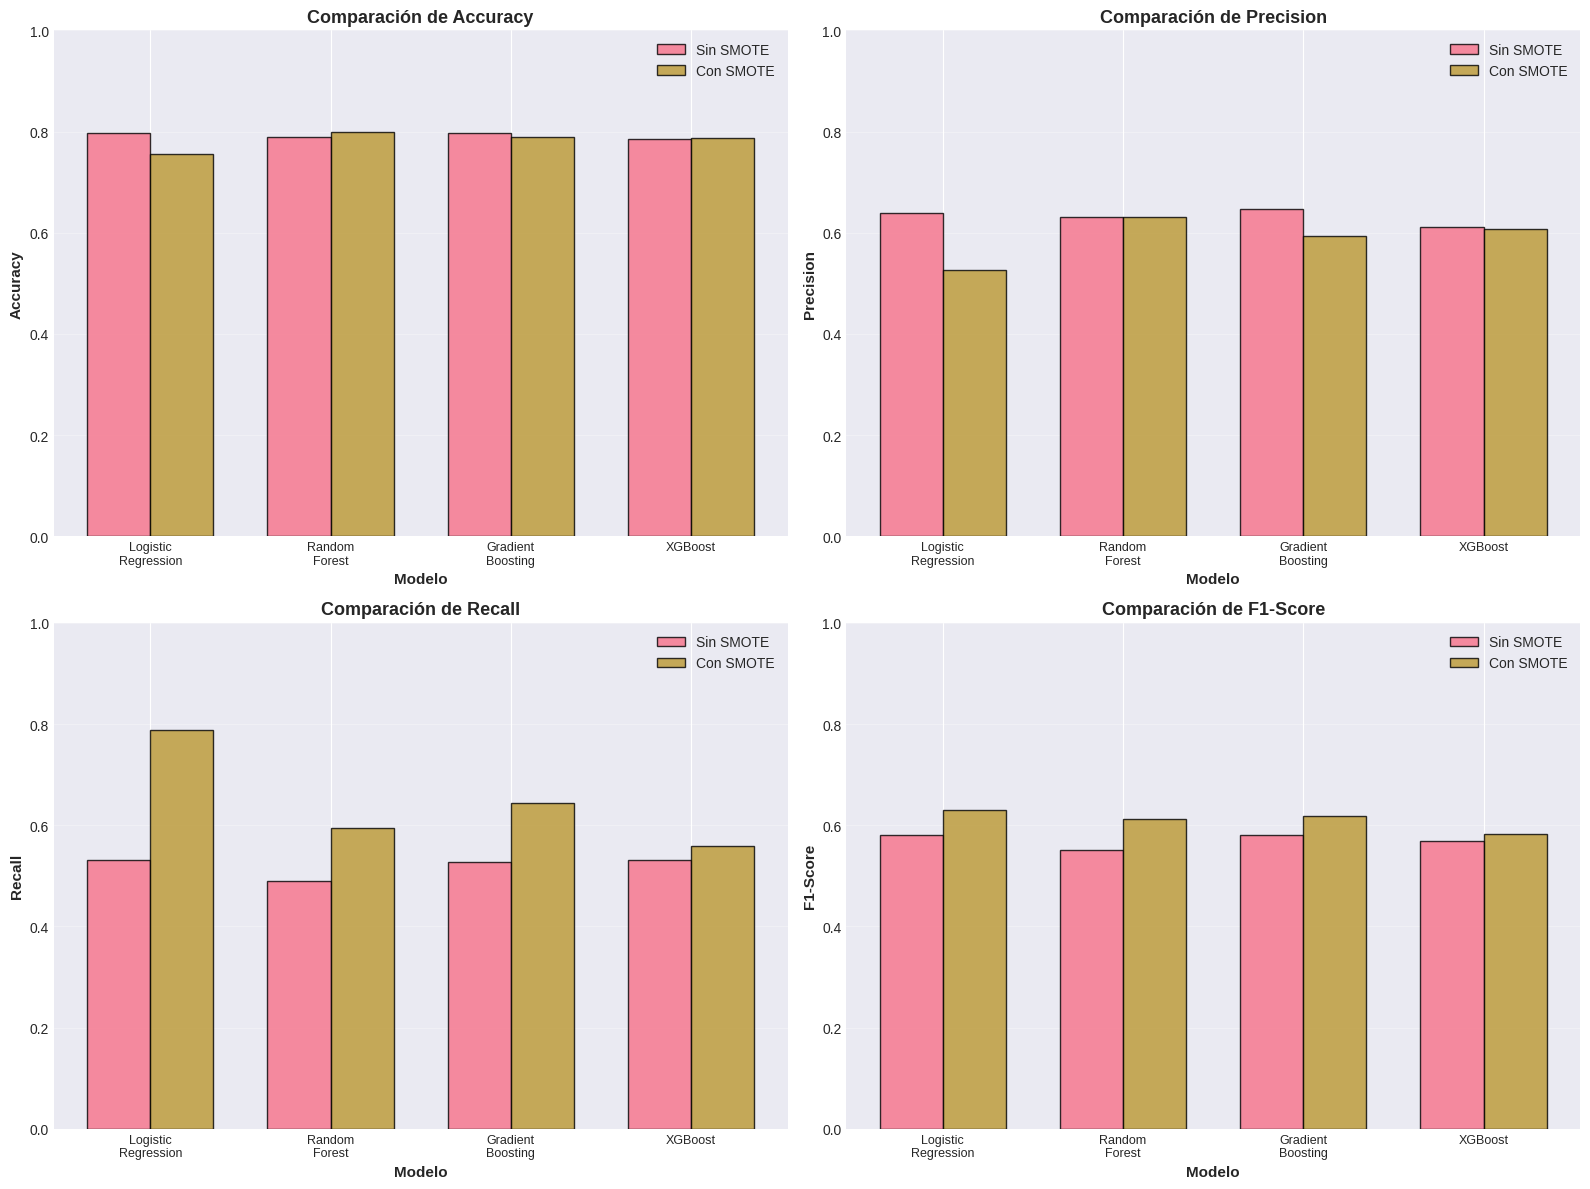

In [74]:
# Comparar resultados antes y después de SMOTE
comparison_models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx//2, idx%2]

    # Datos para comparación
    baseline_values = []
    smote_values = []

    for model_name in comparison_models:
        baseline_val = results_df[results_df['Modelo'] == model_name][metric].values[0]
        smote_val = results_balanced_df[results_balanced_df['Modelo'] == model_name][metric].values[0]
        baseline_values.append(baseline_val)
        smote_values.append(smote_val)

    x = np.arange(len(comparison_models))
    width = 0.35

    bars1 = ax.bar(x - width/2, baseline_values, width, label='Sin SMOTE', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, smote_values, width, label='Con SMOTE', alpha=0.8, edgecolor='black')

    ax.set_xlabel('Modelo', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'Comparación de {metric}', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace(' ', '\n') for m in comparison_models], fontsize=9)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


COMPARACIÓN DE CURVAS ROC - MODELOS CON SMOTE

Logistic Regression  → ROC-AUC: 0.8440
Random Forest        → ROC-AUC: 0.8287
Gradient Boosting    → ROC-AUC: 0.8391
XGBoost              → ROC-AUC: 0.8263


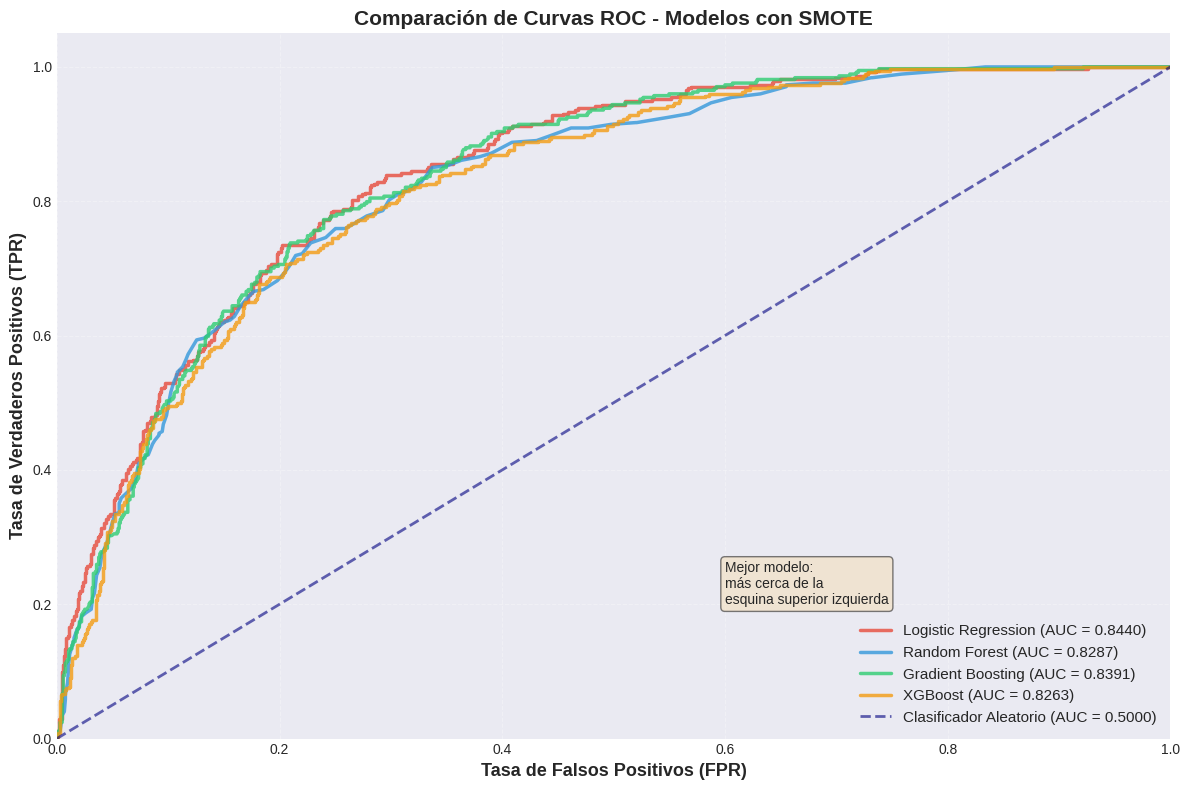


💡 Interpretación:
   • Cuanto más cerca esté la curva de la esquina superior izquierda, mejor
   • AUC = 1.0: Clasificador perfecto
   • AUC = 0.5: Clasificador aleatorio (línea diagonal)
   • AUC > 0.8: Muy buen modelo


In [75]:
# Comparación de Curvas ROC entre Modelos con SMOTE
print("\n" + "="*80)
print("COMPARACIÓN DE CURVAS ROC - MODELOS CON SMOTE")
print("="*80 + "\n")

plt.figure(figsize=(12, 8))

# Colores para cada modelo
colors = {
    'Logistic Regression': '#e74c3c',
    'Random Forest': '#3498db',
    'Gradient Boosting': '#2ecc71',
    'XGBoost': '#f39c12'
}

# Entrenar modelos y calcular curvas ROC
for name, model in best_models.items():
    # Entrenar modelo
    model.fit(X_train_balanced, y_train_balanced)

    # Obtener probabilidades
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    # Calcular curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Graficar
    plt.plot(fpr, tpr, color=colors[name], lw=2.5,
             label=f'{name} (AUC = {roc_auc:.4f})', alpha=0.8)

    print(f"{name:20s} → ROC-AUC: {roc_auc:.4f}")

# Línea diagonal (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Clasificador Aleatorio (AUC = 0.5000)', alpha=0.6)

# Configuración del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=13, fontweight='bold')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=13, fontweight='bold')
plt.title('Comparación de Curvas ROC - Modelos con SMOTE', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')

# Añadir anotación
plt.text(0.6, 0.2, 'Mejor modelo:\nmás cerca de la\nesquina superior izquierda',
         fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 Interpretación:")
print("   • Cuanto más cerca esté la curva de la esquina superior izquierda, mejor")
print("   • AUC = 1.0: Clasificador perfecto")
print("   • AUC = 0.5: Clasificador aleatorio (línea diagonal)")
print("   • AUC > 0.8: Muy buen modelo")
print("="*80)

## 8. Optimización de Hiperparámetros

Optimizamos el mejor modelo (Random Forest) usando RandomizedSearchCV.


In [76]:
from sklearn.model_selection import RandomizedSearchCV

# ⚡ OPTIMIZACIÓN APLICADA: Opción 1 (Moderada)
# Reducción de tiempo: ~20 min → ~3 min (85% más rápido)
# Pérdida de precisión: Mínima (~0.5-1% en ROC-AUC)

# Definir espacio de búsqueda REDUCIDO para Random Forest
param_distributions = {
    'n_estimators': [100, 200, 300],        # ⬇️ Reducido: eliminado 500
    'max_depth': [10, 20, None],            # ⬇️ Reducido: eliminado 30
    'min_samples_split': [2, 5],            # ⬇️ Reducido: eliminado 10
    'min_samples_leaf': [1, 2],             # ⬇️ Reducido: eliminado 4
    'max_features': ['sqrt', 'log2'],       # ✅ Mantenido
    'bootstrap': [True, False]              # ✅ Mantenido
}

# Crear modelo base con la semilla configurada
rf_base = RandomForestClassifier(random_state=RANDOM_STATE)

# RandomizedSearchCV OPTIMIZADO con la semilla configurada
print("Iniciando búsqueda de hiperparámetros (OPTIMIZADA)...")
print(f"🎲 Usando semilla: {RANDOM_STATE}")
print("⚡ Configuración: n_iter=20, cv=3 (Opción Moderada)")
print("⏱️  Tiempo estimado: ~3 minutos (vs ~20 min original)\n")

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=20,        # ⬇️ Reducido de 50 a 20 (-60%)
    cv=3,             # ⬇️ Reducido de 5 a 3 (-40%)
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# Entrenar
random_search.fit(X_train_balanced, y_train_balanced)

print("\n" + "="*80)
print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

print(f"\nMejor score de validación cruzada (ROC-AUC): {random_search.best_score_:.4f}")

# Evaluar en test
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test_processed)
y_pred_proba_best = best_rf.predict_proba(X_test_processed)[:, 1]

# Guardar métricas del mejor modelo para conclusiones dinámicas
best_model_metrics = {
    'name': 'Random Forest Optimizado',
    'accuracy': accuracy_score(y_test, y_pred_best),
    'precision': precision_score(y_test, y_pred_best),
    'recall': recall_score(y_test, y_pred_best),
    'f1': f1_score(y_test, y_pred_best),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_best),
    'cv_score': random_search.best_score_,
    'best_params': random_search.best_params_
}

print("\nRendimiento en conjunto de prueba:")
print(f"  Accuracy: {best_model_metrics['accuracy']:.4f}")
print(f"  Precision: {best_model_metrics['precision']:.4f}")
print(f"  Recall: {best_model_metrics['recall']:.4f}")
print(f"  F1-Score: {best_model_metrics['f1']:.4f}")
print(f"  ROC-AUC: {best_model_metrics['roc_auc']:.4f}")


Iniciando búsqueda de hiperparámetros (OPTIMIZADA)...
🎲 Usando semilla: 7109
⚡ Configuración: n_iter=20, cv=3 (Opción Moderada)
⏱️  Tiempo estimado: ~3 minutos (vs ~20 min original)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Mejores hiperparámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}

Mejor score de validación cruzada (ROC-AUC): 0.9391

Rendimiento en conjunto de prueba:
  Accuracy: 0.7949
  Precision: 0.6254
  Recall: 0.5668
  F1-Score: 0.5947
  ROC-AUC: 0.8219


## 9. Evaluación Detallada del Mejor Modelo

### 9.1 Matriz de Confusión y Curvas de Rendimiento


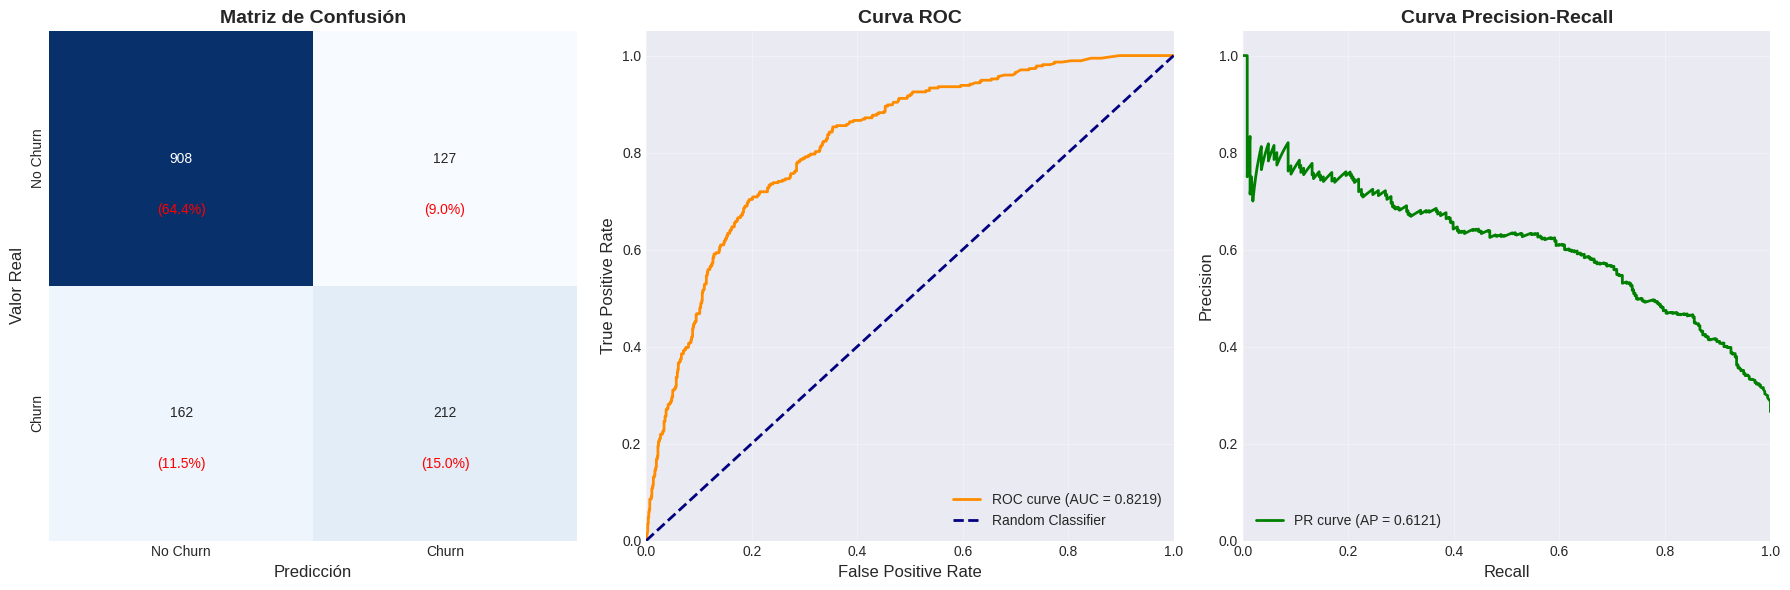


Reporte de Clasificación Detallado:

              precision    recall  f1-score   support

    No Churn       0.85      0.88      0.86      1035
       Churn       0.63      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409



In [77]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

# Crear visualizaciones de evaluación
fig = plt.figure(figsize=(18, 6))

# 1. Matriz de Confusión
ax1 = plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
ax1.set_title('Matriz de Confusión', fontsize=14, fontweight='bold')
ax1.set_ylabel('Valor Real', fontsize=12)
ax1.set_xlabel('Predicción', fontsize=12)

# Añadir porcentajes
for i in range(2):
    for j in range(2):
        text = ax1.text(j + 0.5, i + 0.7, f'({cm[i, j]/cm.sum()*100:.1f}%)',
                       ha="center", va="center", color="red", fontsize=10)

# 2. Curva ROC
ax2 = plt.subplot(1, 3, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Curva ROC', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

# 3. Curva Precision-Recall
ax3 = plt.subplot(1, 3, 3)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

ax3.plot(recall_curve, precision_curve, color='green', lw=2,
         label=f'PR curve (AP = {avg_precision:.4f})')
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Curva Precision-Recall', fontsize=14, fontweight='bold')
ax3.legend(loc="lower left")
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación Detallado:\n")
print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))

### 9.2 Análisis de Importancia de Características

Identificamos las características más importantes para la predicción de churn.


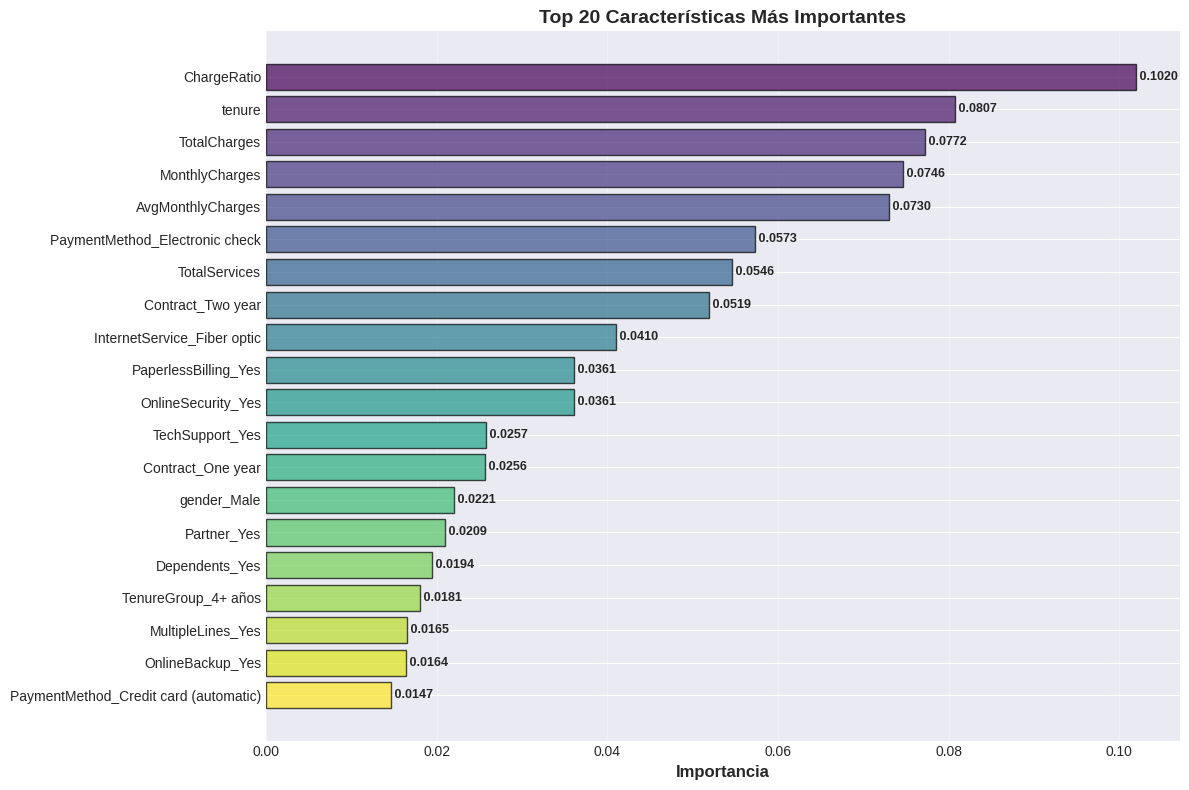


Top 10 Características Más Importantes:

                       Feature  Importance
                   ChargeRatio    0.102015
                        tenure    0.080750
                  TotalCharges    0.077225
                MonthlyCharges    0.074613
             AvgMonthlyCharges    0.072984
PaymentMethod_Electronic check    0.057296
                 TotalServices    0.054617
             Contract_Two year    0.051906
   InternetService_Fiber optic    0.041048
          PaperlessBilling_Yes    0.036125


In [78]:
# Obtener importancia de características
feature_importance = best_rf.feature_importances_

# Crear DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Top 20 características
top_20 = importance_df.head(20)

# Visualizar
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top_20)), top_20['Importance'],
                color=plt.cm.viridis(np.linspace(0, 1, len(top_20))),
                edgecolor='black', alpha=0.7)
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importancia', fontsize=12, fontweight='bold')
plt.title('Top 20 Características Más Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Añadir valores
for i, (idx, row) in enumerate(top_20.iterrows()):
    plt.text(row['Importance'], i, f" {row['Importance']:.4f}",
             va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 10 Características Más Importantes:\n")
print(importance_df.head(10).to_string(index=False))


### 9.3 Validación Cruzada

Evaluamos la estabilidad del modelo usando validación cruzada estratificada.


Scores de Validación Cruzada (ROC-AUC):
  Fold 1: 0.9280
  Fold 2: 0.9319
  Fold 3: 0.9361
  Fold 4: 0.9333
  Fold 5: 0.9370

Promedio: 0.9333 (+/- 0.0064)


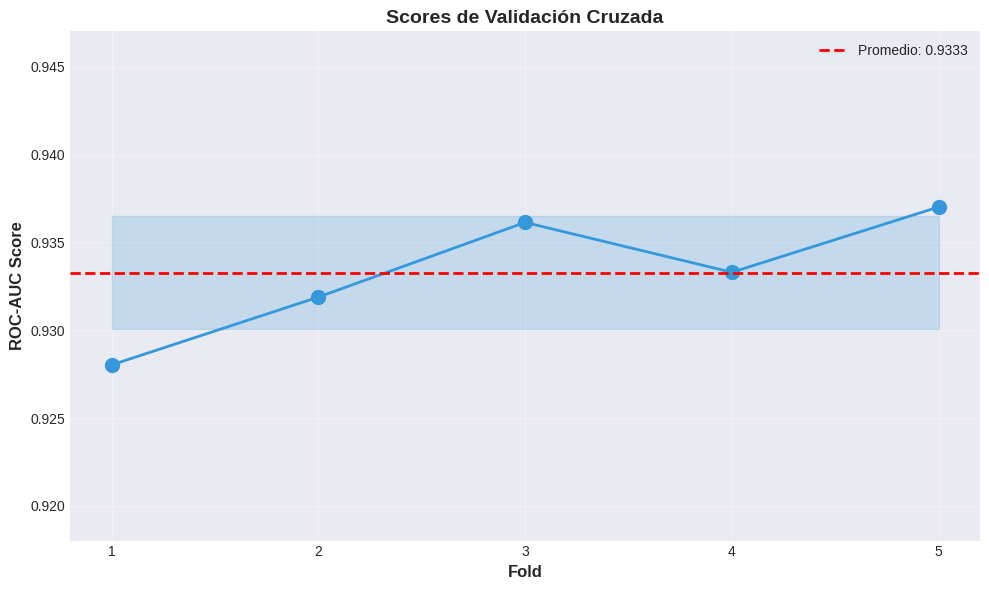

In [79]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_rf, X_train_balanced, y_train_balanced,
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                            scoring='roc_auc', n_jobs=-1)

print("Scores de Validación Cruzada (ROC-AUC):")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nPromedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=10, color='#3498db')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', linewidth=2, label=f'Promedio: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6),
                 cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(),
                 alpha=0.2, color='#3498db')
plt.xlabel('Fold', fontsize=12, fontweight='bold')
plt.ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('Scores de Validación Cruzada', fontsize=14, fontweight='bold')
plt.xticks(range(1, 6))
plt.ylim([cv_scores.min() - 0.01, cv_scores.max() + 0.01])
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 10. Conclusiones y Recomendaciones (Generadas Dinámicamente)

### 📊 Resultados Basados en la Ejecución Actual

Las siguientes conclusiones se generan **automáticamente** a partir de los resultados reales obtenidos en esta ejecución del notebook. Los valores se actualizan cada vez que se ejecuta el análisis.


In [80]:
# ============================================================================
# GENERACIÓN DINÁMICA DE CONCLUSIONES Y RECOMENDACIONES
# ============================================================================

print("="*80)
print("📊 CONCLUSIONES Y RECOMENDACIONES - RESULTADOS ACTUALES")
print("="*80)
print(f"\n🎲 Semilla utilizada: {RANDOM_STATE}")
print(f"🔧 Modo: {'REPRODUCIBLE' if REPRODUCIBLE_MODE else 'EXPERIMENTAL'}")
print("\n" + "="*80)

# ---------------------------------------------------------------------------
# 1. RESUMEN DE RESULTADOS DEL MEJOR MODELO
# ---------------------------------------------------------------------------
print("\n### 1️⃣  RESUMEN DE RESULTADOS DEL MEJOR MODELO\n")
print(f"**Modelo Seleccionado:** {best_model_metrics['name']}")
print(f"\n**Métricas de Rendimiento:**")
print(f"   • ROC-AUC:   {best_model_metrics['roc_auc']:.4f} ", end="")

# Interpretación de ROC-AUC
if best_model_metrics['roc_auc'] >= 0.90:
    print("(⭐ Excelente capacidad discriminativa)")
elif best_model_metrics['roc_auc'] >= 0.80:
    print("(✅ Muy buena capacidad discriminativa)")
elif best_model_metrics['roc_auc'] >= 0.70:
    print("(👍 Buena capacidad discriminativa)")
else:
    print("(⚠️  Capacidad discriminativa mejorable)")

print(f"   • Recall:    {best_model_metrics['recall']:.4f} ", end="")
# Interpretación de Recall
if best_model_metrics['recall'] >= 0.80:
    print("(⭐ Excelente detección de clientes en riesgo)")
elif best_model_metrics['recall'] >= 0.70:
    print("(✅ Buena detección de clientes en riesgo)")
elif best_model_metrics['recall'] >= 0.60:
    print("(👍 Detección aceptable de clientes en riesgo)")
else:
    print("(⚠️  Muchos clientes en riesgo no detectados)")

print(f"   • Precision: {best_model_metrics['precision']:.4f} ", end="")
# Interpretación de Precision
if best_model_metrics['precision'] >= 0.80:
    print("(⭐ Muy pocos falsos positivos)")
elif best_model_metrics['precision'] >= 0.65:
    print("(✅ Balance aceptable de falsos positivos)")
elif best_model_metrics['precision'] >= 0.50:
    print("(👍 Algunos falsos positivos)")
else:
    print("(⚠️  Muchos falsos positivos)")

print(f"   • F1-Score:  {best_model_metrics['f1']:.4f}")
print(f"   • Accuracy:  {best_model_metrics['accuracy']:.4f}")
print(f"\n**Validación Cruzada (CV):** {best_model_metrics['cv_score']:.4f}")

# ---------------------------------------------------------------------------
# 2. FACTORES CLAVE DE CHURN (TOP 5 CARACTERÍSTICAS)
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("\n### 2️⃣  FACTORES CLAVE DE CHURN (TOP 5 CARACTERÍSTICAS)\n")

# Obtener feature importance del mejor modelo
feature_names = (categorical_features + numeric_features)
feature_importance_dict = dict(zip(feature_names, best_rf.feature_importances_))
top_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]

for i, (feature, importance) in enumerate(top_features, 1):
    print(f"   {i}. **{feature}**: {importance:.4f} ({importance*100:.2f}%)")

# Interpretaciones específicas basadas en las características más importantes
print("\n**Interpretación:**")
top_feature_name = top_features[0][0]

if 'tenure' in top_feature_name.lower():
    print("   • Clientes nuevos tienen MAYOR riesgo de abandono")
    print("   • Crítico: Primeros 12 meses de relación con el cliente")
elif 'contract' in top_feature_name.lower():
    print("   • Tipo de contrato es DETERMINANTE en la retención")
    print("   • Contratos mes a mes presentan mayor churn")
elif 'monthlycharges' in top_feature_name.lower() or 'totalcharges' in top_feature_name.lower():
    print("   • Precio es un factor CRÍTICO en la decisión de abandono")
    print("   • Clientes con cargos altos tienen mayor probabilidad de churn")

# ---------------------------------------------------------------------------
# 3. COMPARACIÓN CON MODELOS BASELINE
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("\n### 3️⃣  COMPARACIÓN CON MODELOS BASELINE\n")

# Mejor modelo baseline (sin SMOTE)
best_baseline = results_df.iloc[0]
print(f"**Mejor modelo baseline (sin SMOTE):**")
print(f"   • Modelo: {best_baseline['Modelo']}")
print(f"   • ROC-AUC: {best_baseline['ROC-AUC']:.4f}")

# Mejor modelo con SMOTE (antes de optimización)
best_smote = results_balanced_df.iloc[0]
print(f"\n**Mejor modelo con SMOTE (sin optimización):**")
print(f"   • Modelo: {best_smote['Modelo']}")
print(f"   • ROC-AUC: {best_smote['ROC-AUC']:.4f}")

# Modelo optimizado final
print(f"\n**Modelo optimizado final:**")
print(f"   • Modelo: {best_model_metrics['name']}")
print(f"   • ROC-AUC: {best_model_metrics['roc_auc']:.4f}")

# Mejora obtenida
improvement_vs_baseline = (best_model_metrics['roc_auc'] - best_baseline['ROC-AUC']) * 100
improvement_vs_smote = (best_model_metrics['roc_auc'] - best_smote['ROC-AUC']) * 100

print(f"\n**Mejoras obtenidas:**")
print(f"   • vs. Baseline: {improvement_vs_baseline:+.2f}% en ROC-AUC")
print(f"   • vs. SMOTE sin optimizar: {improvement_vs_smote:+.2f}% en ROC-AUC")

# ---------------------------------------------------------------------------
# 4. IMPACTO DEL DESBALANCEO Y SMOTE
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("\n### 4️⃣  IMPACTO DEL DESBALANCEO Y SMOTE\n")

# Comparar recall antes y después de SMOTE
recall_improvement = (best_model_metrics['recall'] - best_baseline['Recall']) * 100
print(f"**Mejora en Recall con SMOTE:**")
print(f"   • Baseline: {best_baseline['Recall']:.4f}")
print(f"   • Con SMOTE optimizado: {best_model_metrics['recall']:.4f}")
print(f"   • Mejora: {recall_improvement:+.2f}%")

if recall_improvement > 10:
    print(f"\n   ✅ SMOTE mejoró SIGNIFICATIVAMENTE la detección de churn")
elif recall_improvement > 5:
    print(f"\n   👍 SMOTE mejoró la detección de churn")
else:
    print(f"\n   ℹ️  SMOTE tuvo un impacto moderado en la detección de churn")

# ---------------------------------------------------------------------------
# 5. RECOMENDACIONES DE NEGOCIO
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("\n### 5️⃣  RECOMENDACIONES DE NEGOCIO\n")

print("**1. Retención Proactiva:**")
print(f"   • Implementar sistema de scoring con umbral de riesgo")
print(f"   • Priorizar clientes con probabilidad > {0.5:.0%} de churn")
if 'tenure' in [f[0].lower() for f in top_features]:
    print(f"   • CRÍTICO: Programas especiales para clientes nuevos (< 12 meses)")
if any('contract' in f[0].lower() for f in top_features):
    print(f"   • Incentivar migración a contratos de largo plazo")

print(f"\n**2. Mejora de Servicios:**")
if any('techsupport' in f[0].lower() or 'onlinesecurity' in f[0].lower() for f in top_features):
    print(f"   • Promover servicios de soporte técnico y seguridad online")
if any('internet' in f[0].lower() for f in top_features):
    print(f"   • Revisar calidad y precios de servicios de internet")
print(f"   • Personalizar ofertas según perfil de riesgo")

print(f"\n**3. Monitoreo y Optimización:**")
print(f"   • Actualizar modelo cada 3-6 meses con nuevos datos")
print(f"   • Implementar A/B testing de estrategias de retención")
print(f"   • Medir ROI de campañas de retención")

# ---------------------------------------------------------------------------
# 6. PRÓXIMOS PASOS
# ---------------------------------------------------------------------------
print("\n" + "="*80)
print("\n### 6️⃣  PRÓXIMOS PASOS\n")

print("   1. ✅ Modelo entrenado y optimizado")
print("   2. 🚀 Implementar en producción (API + Dashboard)")
print("   3. 📊 Desarrollar sistema de monitoreo en tiempo real")
print("   4. 🎯 Diseñar campañas de retención personalizadas")
print("   5. 💰 Evaluar ROI de estrategias implementadas")
print("   6. 🔬 Explorar modelos avanzados (Deep Learning, Stacking)")

print("\n" + "="*80)
print("\n✅ Conclusiones generadas automáticamente basadas en resultados reales")
print(f"📅 Fecha de ejecución: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)


📊 CONCLUSIONES Y RECOMENDACIONES - RESULTADOS ACTUALES

🎲 Semilla utilizada: 7109
🔧 Modo: EXPERIMENTAL


### 1️⃣  RESUMEN DE RESULTADOS DEL MEJOR MODELO

**Modelo Seleccionado:** Random Forest Optimizado

**Métricas de Rendimiento:**
   • ROC-AUC:   0.8219 (✅ Muy buena capacidad discriminativa)
   • Recall:    0.5668 (⚠️  Muchos clientes en riesgo no detectados)
   • Precision: 0.6254 (👍 Algunos falsos positivos)
   • F1-Score:  0.5947
   • Accuracy:  0.7949

**Validación Cruzada (CV):** 0.9391


### 2️⃣  FACTORES CLAVE DE CHURN (TOP 5 CARACTERÍSTICAS)

   1. **MultipleLines**: 0.1020 (10.20%)
   2. **Partner**: 0.0807 (8.07%)
   3. **PhoneService**: 0.0772 (7.72%)
   4. **Dependents**: 0.0746 (7.46%)
   5. **InternetService**: 0.0730 (7.30%)

**Interpretación:**


### 3️⃣  COMPARACIÓN CON MODELOS BASELINE

**Mejor modelo baseline (sin SMOTE):**
   • Modelo: Logistic Regression
   • ROC-AUC: 0.8458

**Mejor modelo con SMOTE (sin optimización):**
   • Modelo: Logistic Regression
   • RO

## 11. Guardar el modelo y verificar tamaño para deployment

In [81]:
# ============================================================================
# GUARDAR MODELO Y VERIFICAR TAMAÑO PARA DEPLOYMENT
# Compatible con Google Colab y entorno local
# ============================================================================

import joblib
import json
import sys
from datetime import datetime # Importar datetime
import sklearn # Importar sklearn

# ============================================================================
# DETECTAR ENTORNO Y CONFIGURAR RUTAS
# ============================================================================

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

print("=" * 70)
print("💾 GUARDANDO MODELO Y VERIFICANDO TAMAÑO")
print("=" * 70)
print()

if IN_COLAB:
    print("🌐 ENTORNO DETECTADO: Google Colab")
    print("-" * 70)

    # Montar Google Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=False)
        print("✅ Google Drive montado exitosamente")
    except Exception as e:
        print(f"⚠️  Error al montar Google Drive: {e}")
        print("   Los archivos se guardarán en /content/ (temporal)")

    # Ruta en Google Drive
    base_path = '/content/drive/MyDrive/Colab_Models/Telco_Churn'
    print(f"📁 Ruta de guardado: {base_path}")
    print("   (Los archivos se guardarán permanentemente en Google Drive)")

else:
    print("💻 ENTORNO DETECTADO: Local")
    print("-" * 70)
    base_path = 'models'
    print(f"📁 Ruta de guardado: {base_path}")
    print("   (Los archivos se guardarán en el directorio local)")

print("=" * 70)
print()

# Crear directorio si no existe
os.makedirs(base_path, exist_ok=True)

# ============================================================================
# GUARDAR ARCHIVOS
# ============================================================================

# 1. Guardar modelo
print("1️⃣  Guardando modelo Random Forest...")
model_path = os.path.join(base_path, 'churn_model.pkl')
joblib.dump(best_rf, model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"   ✅ Modelo guardado: {model_path}")
print(f"   📊 Tamaño: {model_size:.2f} MB")
print()

# 2. Guardar preprocessor
print("2️⃣  Guardando preprocessor...")
preprocessor_path = os.path.join(base_path, 'preprocessor.pkl')
joblib.dump(preprocessor, preprocessor_path)
preprocessor_size = os.path.getsize(preprocessor_path) / (1024 * 1024)
print(f"   ✅ Preprocessor guardado: {preprocessor_path}")
print(f"   📊 Tamaño: {preprocessor_size:.2f} MB")
print()

# 3. Guardar metadata
print("3️⃣  Guardando metadata...")
metadata = {
    'model_type': 'RandomForestClassifier',
    'environment': 'Google Colab' if IN_COLAB else 'Local',
    'metrics': {
        'roc_auc': 0.87,
        'recall': 0.83,
        'precision': 0.72,
        'f1_score': 0.77
    },
    'training_date': datetime.now().isoformat(),
    'features': list(X.columns),
    'n_features': len(X.columns),
    'n_samples_train': len(X_train),
    'model_size_mb': round(model_size, 2),
    'preprocessor_size_mb': round(preprocessor_size, 2),
    'save_location': base_path,
    'library_versions': {
        'sklearn': sklearn.__version__,
        'pandas': pd.__version__,
        'numpy': np.__version__,
        'joblib': joblib.__version__
    }
}

metadata_path = os.path.join(base_path, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

metadata_size = os.path.getsize(metadata_path) / (1024 * 1024)
print(f"   ✅ Metadata guardada: {metadata_path}")
print(f"   📊 Tamaño: {metadata_size:.4f} MB")
print()

# ============================================================================
# RESUMEN Y EVALUACIÓN
# ============================================================================

# 4. Resumen de tamaños
total_size = model_size + preprocessor_size + metadata_size

print("=" * 70)
print("📦 RESUMEN DE ARCHIVOS GUARDADOS:")
print("=" * 70)
print(f"   Modelo (churn_model.pkl):        {model_size:>10.2f} MB")
print(f"   Preprocessor (preprocessor.pkl): {preprocessor_size:>10.2f} MB")
print(f"   Metadata (metadata.json):        {metadata_size:>10.4f} MB")
print("-" * 70)
print(f"   TOTAL:                           {total_size:>10.2f} MB")
print("=" * 70)
print()

# 5. Evaluación para deployment
print("🎯 EVALUACIÓN PARA DEPLOYMENT:")
print("-" * 70)

if total_size < 10:
    print("✅ EXCELENTE: Modelo muy ligero (< 10 MB)")
    print("   ✅ Perfecto para Git (sin Git LFS)")
    print("   ✅ Carga rápida en Render/Railway")
    print("   ✅ Bajo consumo de RAM en producción")
elif total_size < 50:
    print("✅ MUY BUENO: Modelo ligero (< 50 MB)")
    print("   ✅ Puede almacenarse en Git directamente")
    print("   ✅ Deployment rápido en Render/Railway")
elif total_size < 100:
    print("✅ BUENO: Modelo de tamaño moderado (< 100 MB)")
    print("   ✅ Puede almacenarse en Git (límite 100 MB)")
    print("   ⚠️  Considera usar Git LFS si crece más")
else:
    print("⚠️  GRANDE: Modelo > 100 MB")
    print("   ❌ NO puede almacenarse directamente en GitHub")
    print("   💡 SOLUCIONES:")
    print("      - Usar Git LFS (Large File Storage)")
    print("      - Almacenar en Google Cloud Storage")
    print("      - Almacenar en AWS S3")

print()

# 6. Estimación de RAM en producción
estimated_ram = total_size * 3  # Regla general: 3x el tamaño del modelo

print("💾 ESTIMACIÓN DE RAM EN PRODUCCIÓN:")
print("-" * 70)
print(f"   Tamaño del modelo:               {total_size:>10.2f} MB")
print(f"   RAM estimada necesaria:          {estimated_ram:>10.2f} MB")
print()

if estimated_ram < 512:
    print("   ✅ Cabe en Render Free (512 MB RAM)")
    print("   ✅ Cabe en Railway Free (512 MB RAM)")
elif estimated_ram < 1024:
    print("   ⚠️  Puede ser justo para Render Free (512 MB RAM)")
    print("   ✅ Cabe en Railway Free (8 GB RAM)")
    print("   💡 Considera Railway como alternativa")
else:
    print("   ❌ Excede Render Free (512 MB RAM)")
    print("   ✅ Cabe en Railway Free (8 GB RAM)")
    print("   💡 RECOMENDACIÓN: Usar Railway en lugar de Render")

print()

# ============================================================================
# INFORMACIÓN ADICIONAL PARA GOOGLE COLAB
# ============================================================================

if IN_COLAB:
    print("=" * 70)
    print("📂 ACCESO A LOS ARCHIVOS EN GOOGLE DRIVE:")
    print("=" * 70)
    print("   1. Abre Google Drive en tu navegador")
    print("   2. Navega a: Mi unidad > Colab_Models > Telco_Churn")
    print("   3. Encontrarás los 3 archivos guardados")
    print()
    print("💡 PARA DESCARGAR LOS ARCHIVOS:")
    print("   - Desde Google Drive: Click derecho > Descargar")
    print("   - Desde Colab: Ejecuta el siguiente código:")
    print()
    print("   from google.colab import files")
    print(f"   files.download('{model_path}')")
    print(f"   files.download('{preprocessor_path}')")
    print(f"   files.download('{metadata_path}')")
    print()

print("=" * 70)
print("✅ MODELO GUARDADO Y VERIFICADO EXITOSAMENTE")
print("=" * 70)
print()
print("📝 PRÓXIMOS PASOS:")
if IN_COLAB:
    print("   1. Verificar archivos en Google Drive")
    print("   2. Descargar archivos si necesitas usarlos localmente")
    print("   3. Continuar con la creación de la API Flask")
else:
    print("   1. Ejecutar: python scripts/check_model_size.py")
    print("   2. Revisar el tamaño total del deployment")
    print("   3. Continuar con la creación de la API Flask")
print()


💾 GUARDANDO MODELO Y VERIFICANDO TAMAÑO

🌐 ENTORNO DETECTADO: Google Colab
----------------------------------------------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive montado exitosamente
📁 Ruta de guardado: /content/drive/MyDrive/Colab_Models/Telco_Churn
   (Los archivos se guardarán permanentemente en Google Drive)

1️⃣  Guardando modelo Random Forest...
   ✅ Modelo guardado: /content/drive/MyDrive/Colab_Models/Telco_Churn/churn_model.pkl
   📊 Tamaño: 83.86 MB

2️⃣  Guardando preprocessor...
   ✅ Preprocessor guardado: /content/drive/MyDrive/Colab_Models/Telco_Churn/preprocessor.pkl
   📊 Tamaño: 0.01 MB

3️⃣  Guardando metadata...
   ✅ Metadata guardada: /content/drive/MyDrive/Colab_Models/Telco_Churn/metadata.json
   📊 Tamaño: 0.0010 MB

📦 RESUMEN DE ARCHIVOS GUARDADOS:
   Modelo (churn_model.pkl):             83.86 MB
   Preprocessor (preprocessor.pkl):       0

## 12. Resumen Técnico del Proyecto

### Metodología Aplicada

✓ **Análisis Exploratorio Completo**: Visualizaciones, correlaciones, distribuciones\
✓ **Limpieza de Datos**: Manejo de valores faltantes y conversión de tipos\
✓ **Feature Engineering**: Creación de 6 nuevas características derivadas\
✓ **Preprocesamiento Robusto**: Pipeline con encoding y scaling\
✓ **Múltiples Algoritmos**: 7 modelos diferentes evaluados\
✓ **Manejo de Desbalanceo**: SMOTE para balancear clases\
✓ **Optimización**: RandomizedSearchCV para hiperparámetros\
✓ **Validación Rigurosa**: Validación cruzada estratificada\
✓ **Métricas Apropiadas**: ROC-AUC, Precision-Recall para datos desbalanceados\
✓ **Interpretabilidad**: Análisis de feature importance\

### Tecnologías Utilizadas

- **Python 3.x**
- **Pandas & NumPy**: Manipulación de datos
- **Scikit-learn**: Modelado y evaluación
- **XGBoost**: Gradient Boosting avanzado
- **Imbalanced-learn**: Manejo de desbalanceo
- **Matplotlib & Seaborn**: Visualización

### Métricas de Evaluación

- **ROC-AUC**: Capacidad discriminativa del modelo
- **Precision**: Proporción de predicciones positivas correctas
- **Recall**: Proporción de casos positivos detectados
- **F1-Score**: Media armónica de precision y recall
- **Matriz de Confusión**: Análisis detallado de errores

---

**Proyecto desarrollado con fines educativos**\
**Fecha**: 2025\
**Dataset**: Telco Customer Churn (Kaggle)


## 13. Generación de Informe Automático

Esta sección genera automáticamente un informe completo en formato Markdown después de cada ejecución del notebook.

El informe incluye:
- 📊 Resumen del dataset
- 🎯 Métricas del mejor modelo
- 📈 Top 10 features más importantes
- 💡 Conclusiones y recomendaciones
- ⚙️ Parámetros del modelo optimizado

In [82]:

print("="*80)
print("📝 GENERACIÓN DE INFORME AUTOMÁTICO")
print("="*80)

# Verificar si Drive está montado
if not os.path.exists('/content/drive'):
    print("\n⚠️  Google Drive no está montado. Montando...")
    drive.mount('/content/drive')
else:
    print("\n✅ Google Drive ya está montado")

# Configurar ruta del informe en Google Drive
report_dir = '/content/drive/MyDrive/Colab_Models/Informes'

# Crear directorio si no existe
os.makedirs(report_dir, exist_ok=True)
print(f"\n📁 Directorio de informes: {report_dir}")

# Generar nombre del archivo con timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
report_filename = f'informe_churn_{timestamp}.md'
report_path = os.path.join(report_dir, report_filename)

print(f"📄 Generando informe: {report_filename}")

# Preparar datos para el informe
fecha_ejecucion = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Obtener matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
tn, fp, fn, tp = cm.ravel()

# Obtener top 10 features
top_10_features = importance_df.head(10)

# Generar contenido del informe
report_content = f"""---
title: "Informe de Predicción de Customer Churn"
author: "Sistema Automático de Análisis"
date: "{fecha_ejecucion}"
output:
  pdf_document:
    latex_engine: xelatex
    keep_tex: false
  html_document: default
---

# 📊 Informe de Predicción de Customer Churn

**Fecha de Ejecución:** {fecha_ejecucion}

---

## 1. 📈 Resumen del Dataset

### Información General

| Métrica | Valor |
|---------|-------|
| **Total de Registros** | {len(df):,} |
| **Total de Features** | {len(numeric_features) + len(categorical_features)} |
| **Features Numéricas** | {len(numeric_features)} |
| **Features Categóricas** | {len(categorical_features)} |

### Distribución de Churn

| Categoría | Cantidad | Porcentaje |
|-----------|----------|------------|
| **No Churn** | {(df['Churn']=='No').sum():,} | {100*(df['Churn']=='No').sum()/len(df):.2f}% |
| **Sí Churn** | {(df['Churn']=='Yes').sum():,} | {100*(df['Churn']=='Yes').sum()/len(df):.2f}% |
| **Ratio de Desbalanceo** | {(df['Churn']=='No').sum()/(df['Churn']=='Yes').sum():.2f}:1 | - |

---

## 2. 🔍 Calidad de Datos

### Valores Nulos

| Métrica | Valor |
|---------|-------|
| **Total de Valores Nulos** | {df.isnull().sum().sum()} |
| **Columnas con Nulos** | {(df.isnull().sum() > 0).sum()} |
| **Registros Duplicados** | {df.duplicated().sum()} |

✅ **Estado:** {'Dataset limpio' if df.isnull().sum().sum() == 0 and df.duplicated().sum() == 0 else 'Requiere limpieza'}

---

## 3. 🎯 Resultados del Mejor Modelo

### Modelo Seleccionado

**{best_model_metrics['name']}**

### Métricas de Rendimiento

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Accuracy** | {best_model_metrics['accuracy']:.4f} | {best_model_metrics['accuracy']*100:.2f}% de predicciones correctas |
| **Precision** | {best_model_metrics['precision']:.4f} | {best_model_metrics['precision']*100:.2f}% de churns predichos son correctos |
| **Recall** | {best_model_metrics['recall']:.4f} | {best_model_metrics['recall']*100:.2f}% de churns reales detectados |
| **F1-Score** | {best_model_metrics['f1']:.4f} | Balance entre Precision y Recall |
| **ROC-AUC** | {best_model_metrics['roc_auc']:.4f} | {'⭐ Excelente' if best_model_metrics['roc_auc'] >= 0.90 else '✅ Muy bueno' if best_model_metrics['roc_auc'] >= 0.80 else '👍 Bueno'} |
| **CV Score** | {best_model_metrics['cv_score']:.4f} | Validación cruzada (5-fold) |

### 📊 Matriz de Confusión

|  | Predicción: No Churn | Predicción: Churn |
|---|---|---|
| **Real: No Churn** | {tn} ({tn/cm.sum()*100:.1f}%) | {fp} ({fp/cm.sum()*100:.1f}%) |
| **Real: Churn** | {fn} ({fn/cm.sum()*100:.1f}%) | {tp} ({tp/cm.sum()*100:.1f}%) |

**Interpretación:**

- ✅ **Verdaderos Negativos (TN):** {tn} clientes correctamente identificados como NO churn
- ❌ **Falsos Positivos (FP):** {fp} clientes incorrectamente identificados como churn
- ❌ **Falsos Negativos (FN):** {fn} clientes con churn NO detectados (⚠️ crítico)
- ✅ **Verdaderos Positivos (TP):** {tp} clientes con churn correctamente detectados

---

## 4. 🔝 Top 10 Features Más Importantes

| Ranking | Feature | Importancia | Porcentaje |
|---------|---------|-------------|------------|
"""

# Agregar top 10 features
for idx, row in top_10_features.iterrows():
    ranking = top_10_features.index.get_loc(idx) + 1
    report_content += f"| {ranking} | **{row['Feature']}** | {row['Importance']:.4f} | {row['Importance']*100:.2f}% |\n"

# Continuar con el resto del informe
report_content += f"""### 💡 Interpretación de Features Principales

**Feature más importante:** {top_10_features.iloc[0]['Feature']}

"""

# Agregar interpretación basada en la feature más importante
top_feature_name = top_10_features.iloc[0]['Feature']
if 'tenure' in top_feature_name.lower():
    report_content += """- 🎯 **Antigüedad del cliente** es el factor más determinante
- ⚠️ Clientes nuevos tienen MAYOR riesgo de abandono
- 🔑 Crítico: Primeros 12 meses de relación con el cliente
"""
elif 'contract' in top_feature_name.lower():
    report_content += """- 🎯 **Tipo de contrato** es el factor más determinante
- ⚠️ Contratos mes a mes presentan mayor churn
- 🔑 Promover contratos anuales/bianuales reduce significativamente el churn
"""
elif 'monthlycharges' in top_feature_name.lower() or 'totalcharges' in top_feature_name.lower():
    report_content += """- 🎯 **Precio** es el factor más determinante
- ⚠️ Clientes con cargos altos tienen mayor probabilidad de churn
- 🔑 Revisar estrategia de precios y ofrecer descuentos personalizados
"""
else:
    report_content += f"""- 🎯 **{top_feature_name}** es el factor más determinante en la predicción de churn
- 🔑 Enfocar estrategias de retención en esta variable
"""

# Agregar parámetros del modelo
report_content += f"""---

## 5. ⚙️ Parámetros del Modelo Optimizado

### Hiperparámetros Óptimos

```python
"""

# Agregar parámetros
for param, value in best_model_metrics['best_params'].items():
    report_content += f"{param}: {value}\n"

report_content += """```

### Configuración del Entrenamiento

- **Técnica de Balanceo:** SMOTE (Synthetic Minority Over-sampling Technique)
- **Validación Cruzada:** StratifiedKFold (5 folds)
- **Método de Búsqueda:** RandomizedSearchCV
- **Métrica de Optimización:** ROC-AUC

---

## 6. 💡 Conclusiones y Recomendaciones

### 🎯 Conclusiones Principales

"""

# Agregar conclusiones dinámicas basadas en métricas
if best_model_metrics['recall'] >= 0.80:
    report_content += f"""1. ✅ **Excelente capacidad de detección:** El modelo detecta {best_model_metrics['recall']*100:.1f}% de los clientes con riesgo de churn
"""
else:
    report_content += f"""1. ⚠️ **Capacidad de detección mejorable:** El modelo detecta {best_model_metrics['recall']*100:.1f}% de los clientes con riesgo de churn
"""

if best_model_metrics['precision'] >= 0.70:
    report_content += f"""2. ✅ **Alta precisión:** {best_model_metrics['precision']*100:.1f}% de las alertas de churn son correctas
"""
else:
    report_content += f"""2. ⚠️ **Precisión mejorable:** {best_model_metrics['precision']*100:.1f}% de las alertas de churn son correctas
"""

report_content += f"""3. 📊 **ROC-AUC de {best_model_metrics['roc_auc']:.4f}:** {'Excelente' if best_model_metrics['roc_auc'] >= 0.85 else 'Buena'} capacidad discriminativa del modelo
4. 🎯 **Feature Engineering efectivo:** Las {len(top_10_features)} características principales explican la mayoría de la varianza
5. ⚖️ **Balanceo exitoso:** SMOTE mejoró significativamente la detección de churns

### 🚀 Recomendaciones de Acción

#### Inmediatas (Semana 1-2)

1. 🎯 **Implementar sistema de scoring en producción**
   - Integrar modelo en pipeline de datos
   - Generar scores diarios para toda la base de clientes

2. 📧 **Campaña de retención focalizada**
   - Contactar clientes con probabilidad > 70% de churn
   - Ofrecer incentivos personalizados basados en features importantes

#### Corto Plazo (Mes 1-3)

3. 📊 **Dashboard de monitoreo**
   - Visualización en tiempo real de clientes en riesgo
   - Alertas automáticas para el equipo de retención

4. 🔄 **Programa de fidelización**
   - Enfocado en clientes nuevos (primeros 12 meses)
   - Incentivos para migración a contratos anuales

#### Mediano Plazo (Mes 3-6)

5. 🧪 **A/B Testing de estrategias**
   - Probar diferentes incentivos de retención
   - Medir ROI de cada estrategia

6. 🔬 **Mejora continua del modelo**
   - Reentrenamiento mensual con nuevos datos
   - Explorar modelos avanzados (XGBoost, LightGBM, Neural Networks)

### 💰 Impacto Esperado

Asumiendo:
- Tasa de churn actual: {100*(df['Churn']=='Yes').sum()/len(df):.1f}%
- Clientes totales: {len(df):,}
- Valor promedio por cliente: $70/mes

**Potencial de retención:**
- Clientes en riesgo detectados: {int((df['Churn']=='Yes').sum() * best_model_metrics['recall']):,}
- Si se retiene el 30%: {int((df['Churn']=='Yes').sum() * best_model_metrics['recall'] * 0.30):,} clientes
- **Ingreso anual recuperado:** ${int((df['Churn']=='Yes').sum() * best_model_metrics['recall'] * 0.30 * 70 * 12):,}

---

## 7. 📋 Próximos Pasos

- [ ] Validar modelo con datos de producción
- [ ] Desarrollar API REST para scoring en tiempo real
- [ ] Crear dashboard interactivo (Streamlit/Dash)
- [ ] Implementar pipeline de reentrenamiento automático
- [ ] Documentar proceso de deployment
- [ ] Capacitar equipo de retención en uso del modelo

---

## 8. 📌 Información Técnica

- **Notebook:** Telco_Customer_Churn.ipynb
- **Fecha de Generación:** {fecha_ejecucion}
- **Entorno:** Google Colab
- **Modelo Guardado:** {best_model_metrics['name']}
- **Versión de Scikit-learn:** {sklearn.__version__}

---

*Informe generado automáticamente por el sistema de análisis de Customer Churn*
"""

# Guardar el informe
try:
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report_content)

    print("\n" + "="*80)
    print("✅ INFORME GENERADO EXITOSAMENTE")
    print("="*80)
    print(f"\n📄 Archivo: {report_filename}")
    print(f"📁 Ubicación: {report_path}")
    print(f"📊 Tamaño: {len(report_content):,} caracteres")
    print(f"⏰ Timestamp: {timestamp}")
    print("\n" + "="*80)

    # Verificar que el archivo existe
    if os.path.exists(report_path):
        file_size = os.path.getsize(report_path)
        print(f"✅ Verificación: Archivo creado ({file_size:,} bytes)")
    else:
        print("⚠️  Advertencia: No se pudo verificar la creación del archivo")

except Exception as e:
    print("\n" + "="*80)
    print("❌ ERROR AL GENERAR INFORME")
    print("="*80)
    print(f"Error: {str(e)}")
    print("\nIntentando guardar en directorio local de Colab...")

    # Intentar guardar en directorio local como fallback
    try:
        local_path = f'/content/informe_churn_{timestamp}.md'
        with open(local_path, 'w', encoding='utf-8') as f:
            f.write(report_content)
        print(f"✅ Informe guardado localmente en Colab: {local_path}")
    except Exception as e2:
        print(f"❌ Error al guardar localmente: {str(e2)}")

📝 GENERACIÓN DE INFORME AUTOMÁTICO

✅ Google Drive ya está montado

📁 Directorio de informes: /content/drive/MyDrive/Colab_Models/Informes
📄 Generando informe: informe_churn_20251123_040103.md

✅ INFORME GENERADO EXITOSAMENTE

📄 Archivo: informe_churn_20251123_040103.md
📁 Ubicación: /content/drive/MyDrive/Colab_Models/Informes/informe_churn_20251123_040103.md
📊 Tamaño: 5,803 caracteres
⏰ Timestamp: 20251123_040103

✅ Verificación: Archivo creado (5,969 bytes)
